### Udacity Data Analysis Nanodegree
### Project 5: Communicate data findings
---

# Predicting flight delays
## by Juanita Smith


<!-- <img src="../images/flights.png" alt="drawing" width="550"/> -->

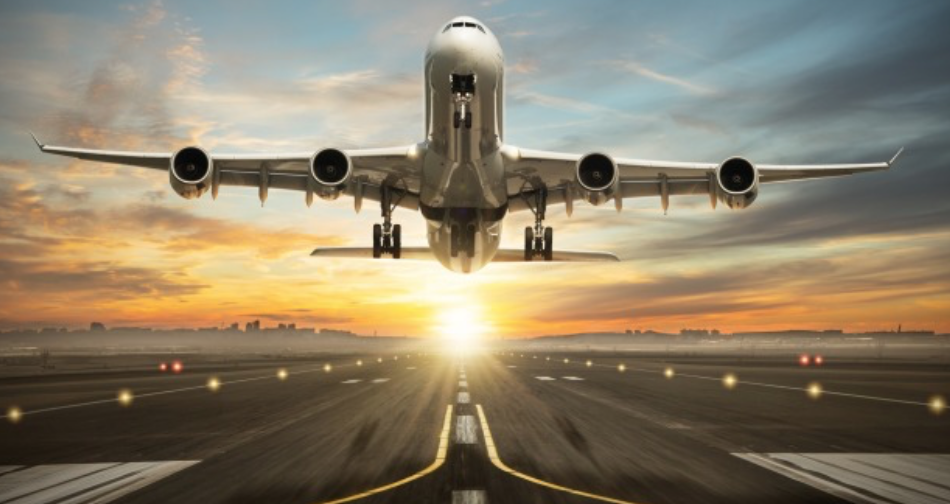

In [41]:
from IPython.display import display, Image
display(Image(filename="../images/flights.png", width=550))

<span style="text-align: center; color:blue; font-size:30px; line-height:40px; font-family: Arial Black;">Investigation Overview</span>

<span style="text-align: center; color:black; font-size:14px; line-height:40px; font-family: Arial Black;">Have you ever been stuck in an airport because your flight was delayed and wondered if you could have predicted it if you'd had more data? This is our chance to find out!</span>

<div style="font-size: 14px;">

In this investigation, I wanted to explore which characteristics predict delays the most. Several avenues were explored: seasonality patterns, airport/carrier relationships, distance (short haul vs long haul flights) and multiple lane repetitions per day.<br><br>
    
<strong>Key insights:</strong><br>
    
<ol>
<li>Setting the scene by showing distribution of flights - 21% of flights are delayed</li>
<li>Seasonal peaks are the main reason for delays</li>
<li>Carrier and Airport Analysis: All airports and carriers will have delays during seasonal peaks, however certain airport and carrier relationships have delays above average</li>
<li>What are the reasons for higher than average delays for certain airport/carrier relationships ?</li>
</ol>  
</div>

<br>

## Dataset Overview<br>

<div style="font-size: 14px;">
This dataset reports flights in the United States, including carriers, arrival and departure delays, with reasons for delays, from 1987 to 2008. Due to large data volume, only years 2003 - 2007 will analysed in this project.
</div>    

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os


import seaborn as sns
import time
import glob

# clear the garbage to free memory as we are working with huge datasets
import gc 

# Import custom modules
from src.utils import reduce_mem_usage, create_folder, change_width
import src.visuals as vs

# set plots to be embedded inline
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# # Make your Jupyter Notebook wider
from IPython.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

# environment settings
# display all columns and rows during visual inspection
pd.options.display.max_columns = 4000
pd.options.display.max_rows = 20000
pd.options.display.max_colwidth = 4000

from pylab import rcParams
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('svg')

# use high resolution if this project is run on an apple device
%config InlineBackend.figure_format='retina'

In [2]:
# set default plot formatting
BASE_COLOR, BASE_HIGHLIGHT_INTENSE, BASE_HIGHLIGHT, BASE_COMPLEMENTRY, BASE_GREY, BASE_COLOR_ARR, BASE_COLOR_DEP, SYMBOLS = vs.set_plot_defaults()

In [3]:
# from importlib import reload
# reload(vs)

In [4]:
# load in the cleaned dataset into a pandas dataframe
FILE_NAME_ENHANCED = '../data/flights_enhanced.pkl'
flights = pd.read_pickle(FILE_NAME_ENHANCED)
flights.sample(5)

year  month  day  dayOfWeek         depTime         arrTime  \
16633528  2005      6   27          1 0 days 17:11:00 0 days 18:10:00   
32712723  2007      8   10          5 0 days 15:36:00 0 days 17:56:00   
9991080   2004      6   11          5 0 days 10:01:00 0 days 11:05:00   
10708808  2004      8   12          4 0 days 10:10:00 0 days 15:49:00   
12129528  2004     10   19          2 0 days 18:28:00 0 days 19:41:00   

         uniqueCarrier tailNum  actualElapsedTime  airTime  arrDelay  \
16633528            US  N335US               59.0     44.0       0.0   
32712723            NW  N529US              320.0    284.0      19.0   
9991080             DL  N902DL               64.0     36.0       0.0   
10708808            WN  N744SW              219.0    195.0       0.0   
12129528            DL  N901DE               73.0     39.0      49.0   

          depDelay origin dest  distance  taxiIn  taxiOut  cancelled  \
16633528       0.0    ORF  PHL       211     5.0     10.0      False   
32712723       0.0    DTW  SFO      2079     9.0     27.0      False   
9991080        0.0    ATL  SAV       215     4.0     24.0      False   
10708808       0.0    ABQ  MCO      1552     9.0     15.0      False   
12129528      49.0    ATL  CHS       259     5.0     29.0      False   

         cancellationCode  diverted  carrierDelay  weatherDelay  NASDelay  \
16633528              NaN     False           0.0           0.0       0.0   
32712723              NaN     False           0.0           0.0      19.0   
9991080               NaN     False           0.0           0.0       0.0   
10708808              NaN     False           0.0           0.0       0.0   
12129528              NaN     False           8.0           0.0       0.0   

          securityDelay  lateAircraftDelay  hour               dateh  \
16633528            0.0                0.0  17.0 2005-06-27 17:00:00   
32712723            0.0                0.0  15.0 2007-08-10 15:00:00   
9991080             0.0                0.0  10.0 2004-06-11 10:00:00   
10708808            0.0                0.0  10.0 2004-08-12 10:00:00   
12129528            0.0               41.0  18.0 2004-10-19 18:00:00   

               date flight_status     lane  
16633528 2005-06-27       on_time  ORF-PHL  
32712723 2007-08-10       delayed  DTW-SFO  
9991080  2004-06-11       on_time  ATL-SAV  
10708808 2004-08-12       on_time  ABQ-MCO  
12129528 2004-10-19       delayed  ATL-CHS

In [5]:
# get carrier descriptions
carriers = pd.read_csv('../data/lookup_tables/carriers.csv', index_col='Code')
carriers = carriers.rename(columns={'Description': 'carrier_description'})
carriers.index.name = 'uniqueCarrier'
carriers.fillna('unknown', axis=1, inplace=True)
carriers['carrier_description'].replace(["Air Lines"], "Airlines", inplace=True, regex=True)
carriers.sample(5)

carrier_description
uniqueCarrier                             
BFQ                   Buffalo Airways Inc.
ROY            Royal American Airways Inc.
CSK                  Catskill Airways Inc.
2M                 Midway Express Airlines
XAY                                Pat Air

In [6]:
# get airport descriptions
airports = pd.read_csv('../data/lookup_tables/airports.csv', index_col='iata')
airports.fillna('unknown', axis=1, inplace=True)
airports['airport'].replace(["International", "Int'l"], "Intl", inplace=True, regex=True)
airports[1000:1005]

airport         city state country  \
iata                                                                  
BRD   Brainerd-Crow Wing County Regional     Brainerd    MN     USA   
BRL                 Burlington Municipal   Burlington    IA     USA   
BRO      Brownsville/S.Padre Island Intl  Brownsville    TX     USA   
BRW      Wiley Post Will Rogers Memorial       Barrow    AK     USA   
BRY                             Samuels     Bardstown    KY     USA   

            lat        long  
iata                         
BRD   46.397858  -94.137227  
BRL   40.783225  -91.125506  
BRO   25.906833  -97.425861  
BRW   71.285448 -156.766002  
BRY   37.814322  -85.499638

<span style="text-align: center; color:blue; font-size:30px; line-height:40px; font-family: Arial Black;">1. Distribution of flights</span>
<div style="font-size: 14px;">
How many flights gets delayed or cancelled ?
</div>

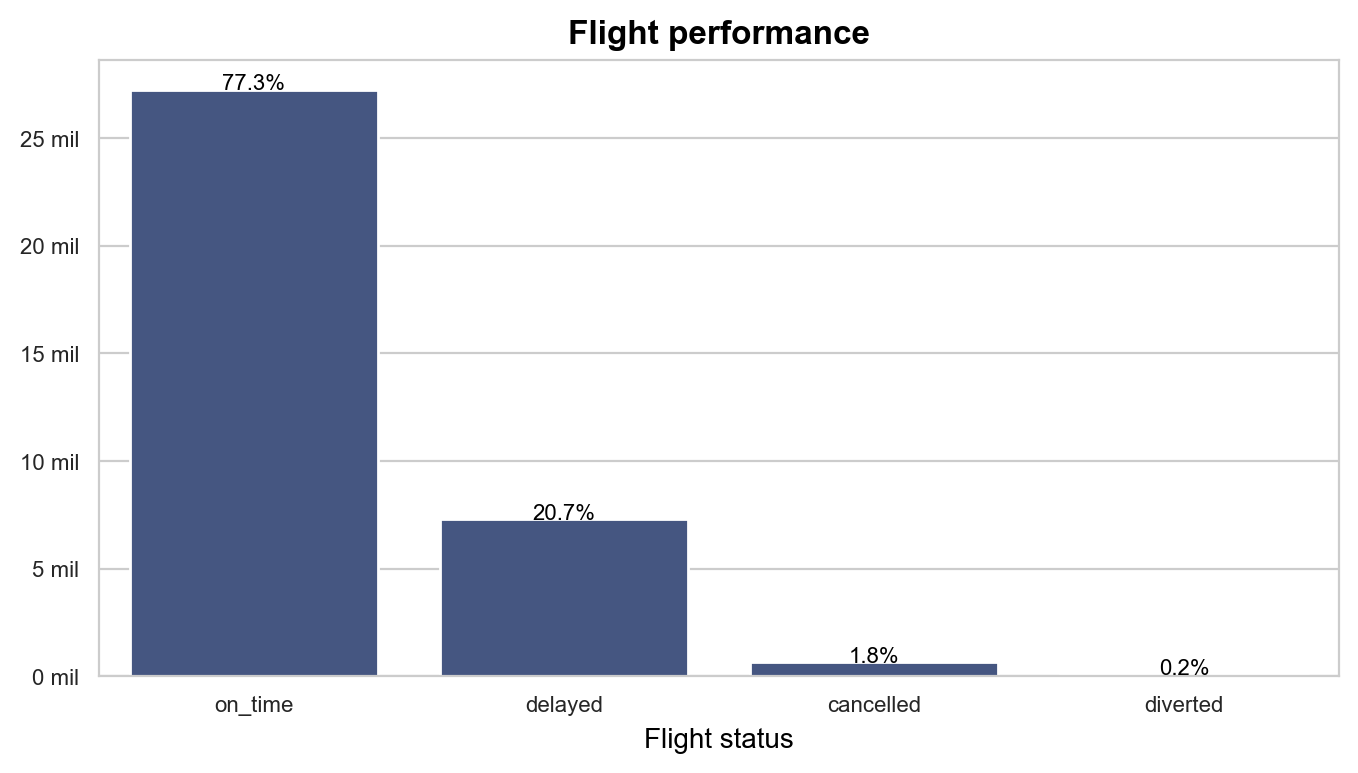

In [7]:
# calculate number of flights per flight status
flight_status_summary = flights['flight_status'].value_counts(normalize=True)
flight_status = flights['flight_status'].value_counts()


sns.barplot(x=flight_status.index, y=flight_status, color=BASE_COLOR)
plt.ylabel('')
plt.xlabel('Flight status')
plt.title('Flight performance')

locs, labels = plt.xticks()

# for each bar, print a % text at the top of each bar
for loc, label in zip(locs,labels):
    count = flight_status[label.get_text()]
    perc = flight_status_summary[label.get_text()]
    pct_string = '{:0.1f}%'.format(perc*100)
    plt.text(loc, count+0.01, pct_string, ha='center', color='black', size=8, weight='ultralight')

# improve y axis
ticks = np.arange(0, flight_status[0], 5000000)
labels = ['{:1.0f} mil'.format(tick/1000000) for tick in ticks]
plt.yticks(ticks,labels)

plt.show()

<div style="font-size: 14px;">
<strong>Conclusion:</strong><br>
Around 77% of flights are on time, where as 21% are delayed. Only 2% of flights are cancelled or diverted.
</div>

In [8]:
# remove cancelled and diverted flights from the dataset as this is not our main focus
flights = flights.loc[flights['flight_status'].isin(['on_time', 'delayed'])]

<span style="text-align: center; color:blue; font-size:30px; line-height:40px; font-family: Arial Black;">2. Seasonal peaks are the main reason for delays</span>

<div style="font-size: 14px;">
When is the best time of year/day of week/time of day to fly to minimise delays?
</div>

***
<span style="text-align: center; color:blue; font-size:20px; line-height:40px; font-family: Arial Black;">2a. Seasonal Analysis: Trend and Time series using statmodels</span>

In [10]:
# build a timeseries dataset with datatime field as index
flight_timeseries_day = flights.groupby('dateh')['flight_status'].value_counts().unstack()
flight_timeseries_day['total_flights'] = flight_timeseries_day.sum(axis=1)

# summarize by month
freq = 'M'
flight_timeseries_month = flight_timeseries_day.resample(freq).sum()

In [12]:
# print seasonal patterns using stats models
flight_timeseries_month.dropna(inplace=True)
decomposition_delays = sm.tsa.seasonal_decompose(flight_timeseries_month['delayed'], extrapolate_trend='freq')

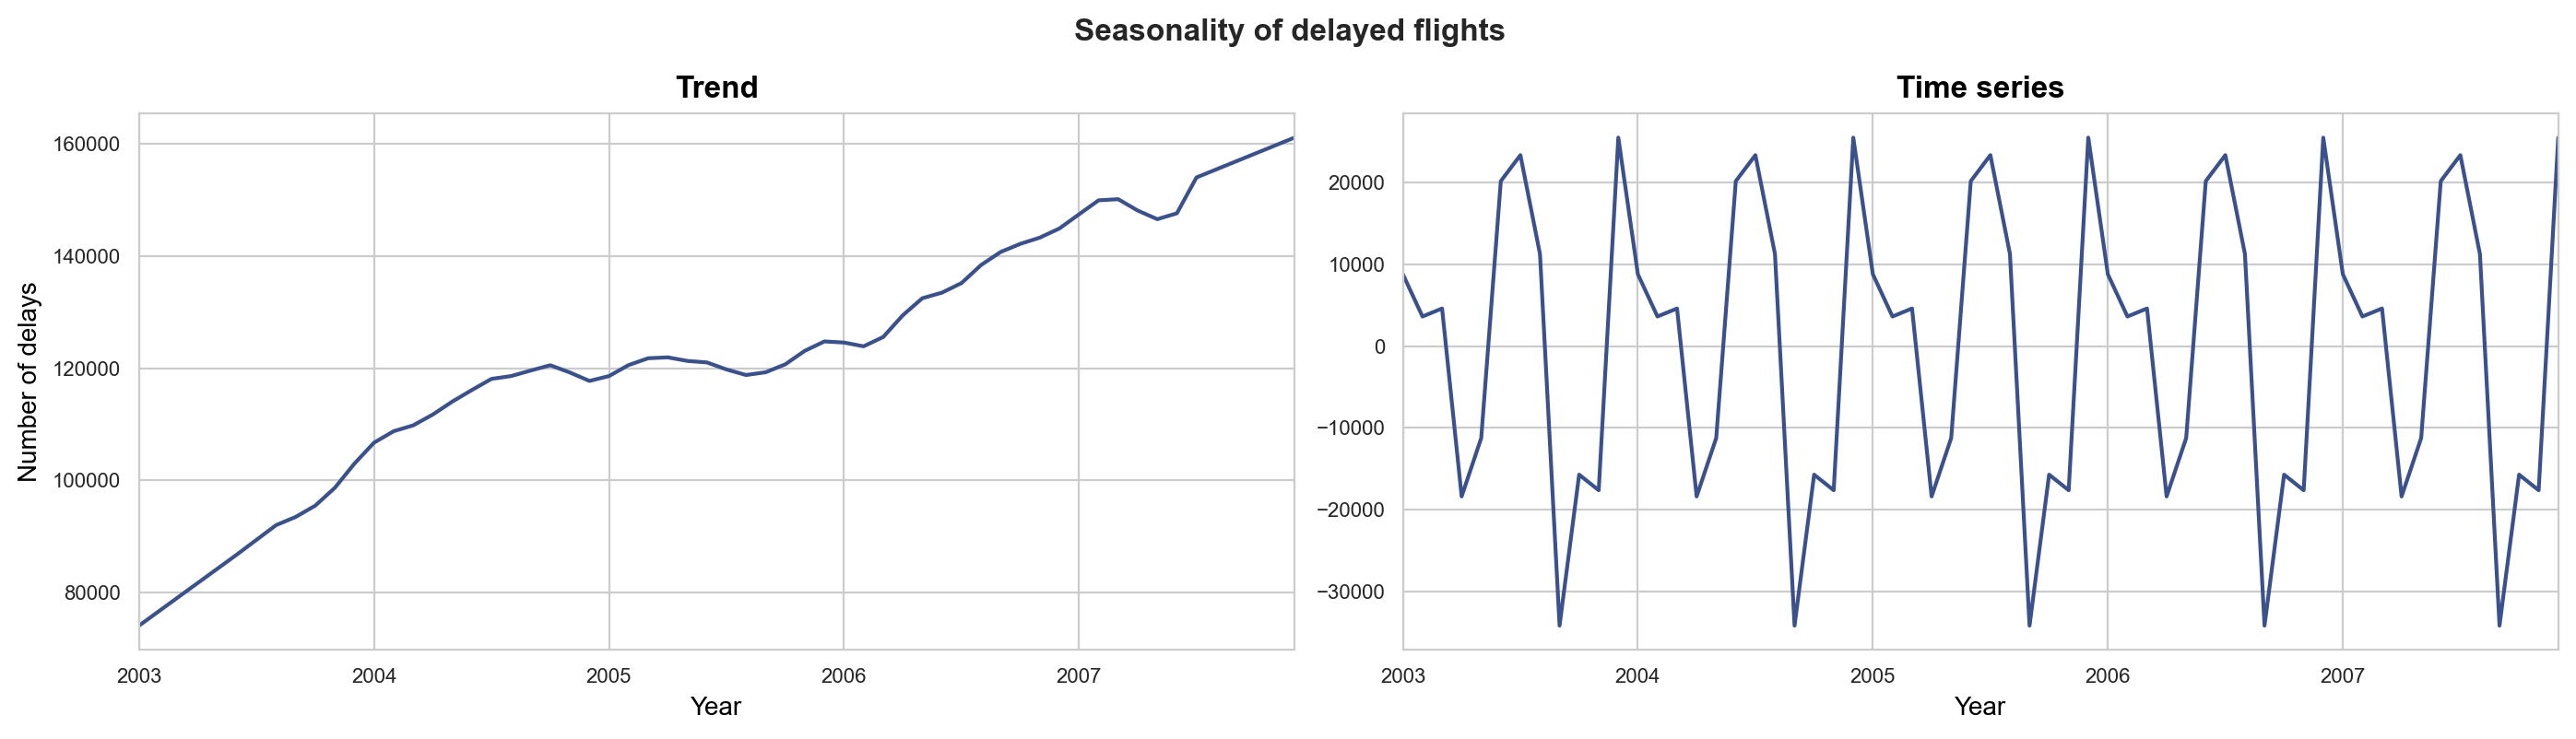

In [13]:
# Plot the trend
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
trend = decomposition_delays.trend
trend.plot(color=BASE_COLOR)
plt.xlabel('Year')
plt.ylabel('Number of delays')
plt.title('Trend')

# extract the seasional pattern
plt.subplot(1,2,2)
season = decomposition_delays.seasonal
season.plot(color=BASE_COLOR)
plt.xlabel('Year')
plt.title('Time series')

plt.suptitle('Seasonality of delayed flights')
plt.tight_layout()
plt.show()

<div style="font-size: 14px;">
<strong>Conclusion:</strong><br>
<ul>
<li>There is an upwards trend in delayed flights year upon year.</li>
<li>There is a strong seasonal pattern re-occuring every year. The trend is removed from the time series and the average of this de-trended series for each period is the returned seasonal component</li>
</div>

<span style="text-align: center; color:blue; font-size:20px; line-height:40px; font-family: Arial Black;">2b. Seasonal Analysis: Monthly Distribution</span>

<div style="font-size: 14px;">
In the first plot on the left in blue, which focus on the distribution of <strong>delayed</strong> flights, there are <strong>2 strong peaks</strong> visible:
<ul>
<li>Christmas period in <em>December - March</em></li>
<li>During summer months <em>June - August</em></li>
</ul>
<br><br>In the second plot on the right in grey, which plot the distribution of <strong>all</strong> flights, there is not much variation in the total flights per month <strong>even in the peak periods</strong>.
</div>

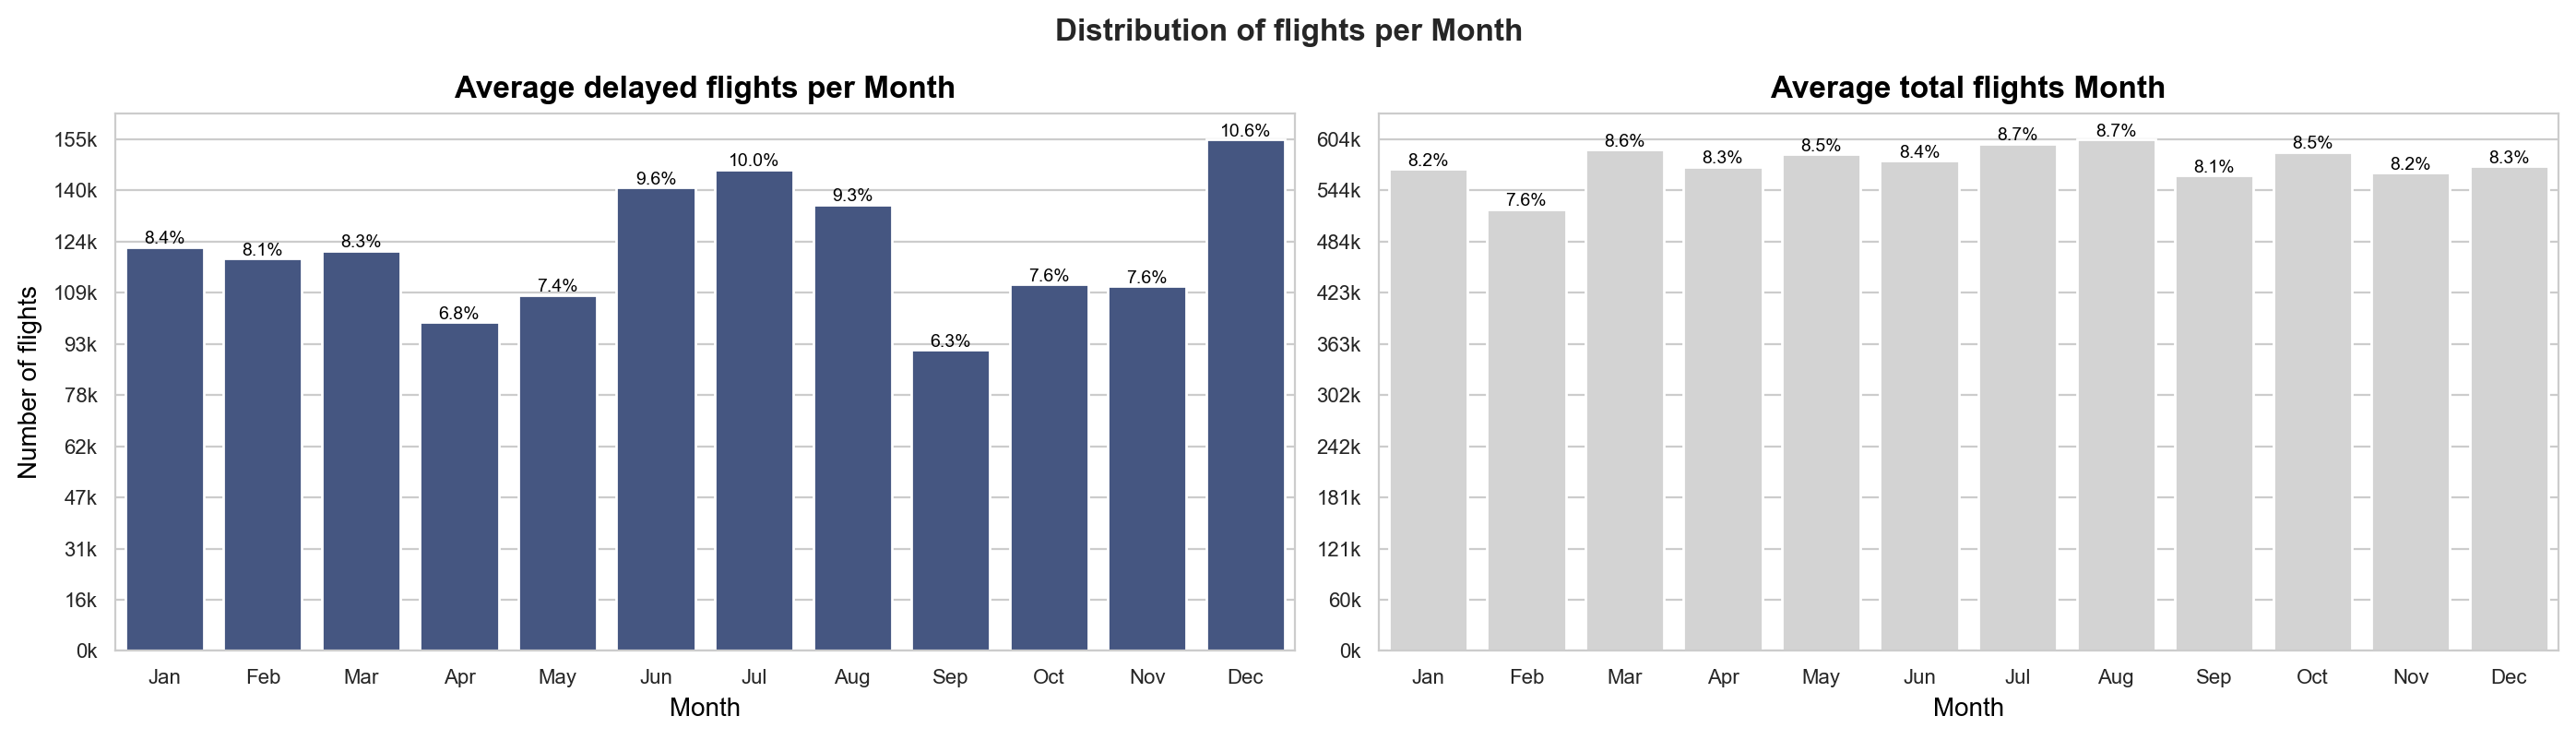

In [14]:
vs.plot_period_side_by_side(df=flight_timeseries_month, col=flight_timeseries_month.index.strftime('%b'), annotate=True, title='Month', rotate=False, sharey=False)

<div style="font-size: 14px;">
<strong>Conclusion:</strong> 
Airports are more busy during peak periods, even though number of flights do not increase. This might be due to an increase in passengers in airports on fully booked flights.
</div>

<span style="text-align: center; color:blue; font-size:20px; line-height:40px; font-family: Arial Black;">2c. Seasonal Analysis: Weekday Distribution</span>

<div style="font-size: 14px;">

<br>In the first plot on the left in blue, which focus on the distribution of <strong>delayed</strong> flights, delays are more likely to happen on Mondays, Thursdays and Fridays.<br>
<br>In the second plot on the right in grey, which plot the distribution of <strong>all</strong> flights, weekdays have the same number of flights, weekends are more quiet

</div>

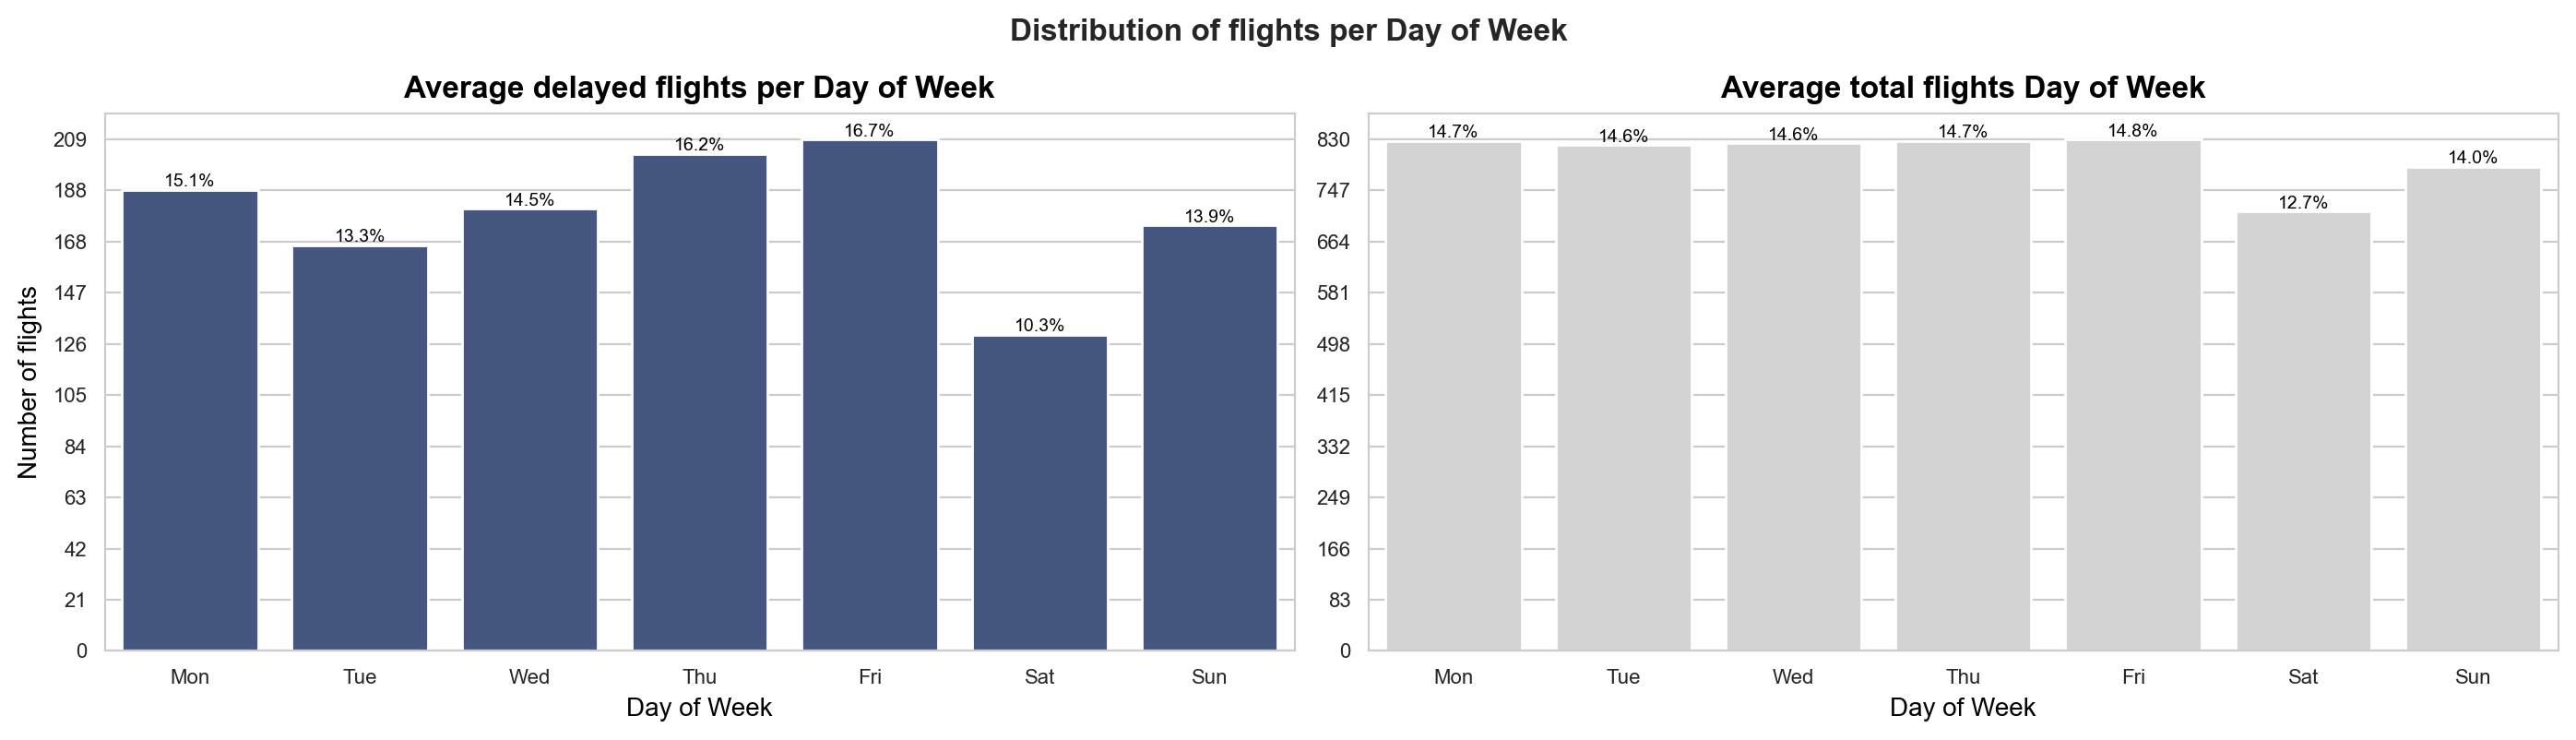

In [15]:
vs.plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.strftime('%a'), annotate=True, title='Day of Week', rotate=False, sharey=False, 
                            order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

<div style="font-size: 14px;">
<strong>Conclusion:</strong>
- Most delays happens on weekdays on <strong>Mondays, Thursdays and Fridays</strong>. Tuesdays and Saturdays are the quietest days. Airports are less busy with less delays on weekends.
</div>

<span style="text-align: center; color:blue; font-size:20px; line-height:40px; font-family: Arial Black;">2d Seasonal Analysis: Time of day Distribution</span>

<div style="font-size: 14px;">
<br>In the first plot on the left in blue, which focus on the distribution of <strong>delayed</strong> flights, delays are more likely to happen on Mondays, Thursdays and Fridays.<br>
<br>In the second plot on the right in grey, which plot the distribution of <strong>all</strong> flights, weekdays have the same number of flights, weekends are more quiet.
</div>

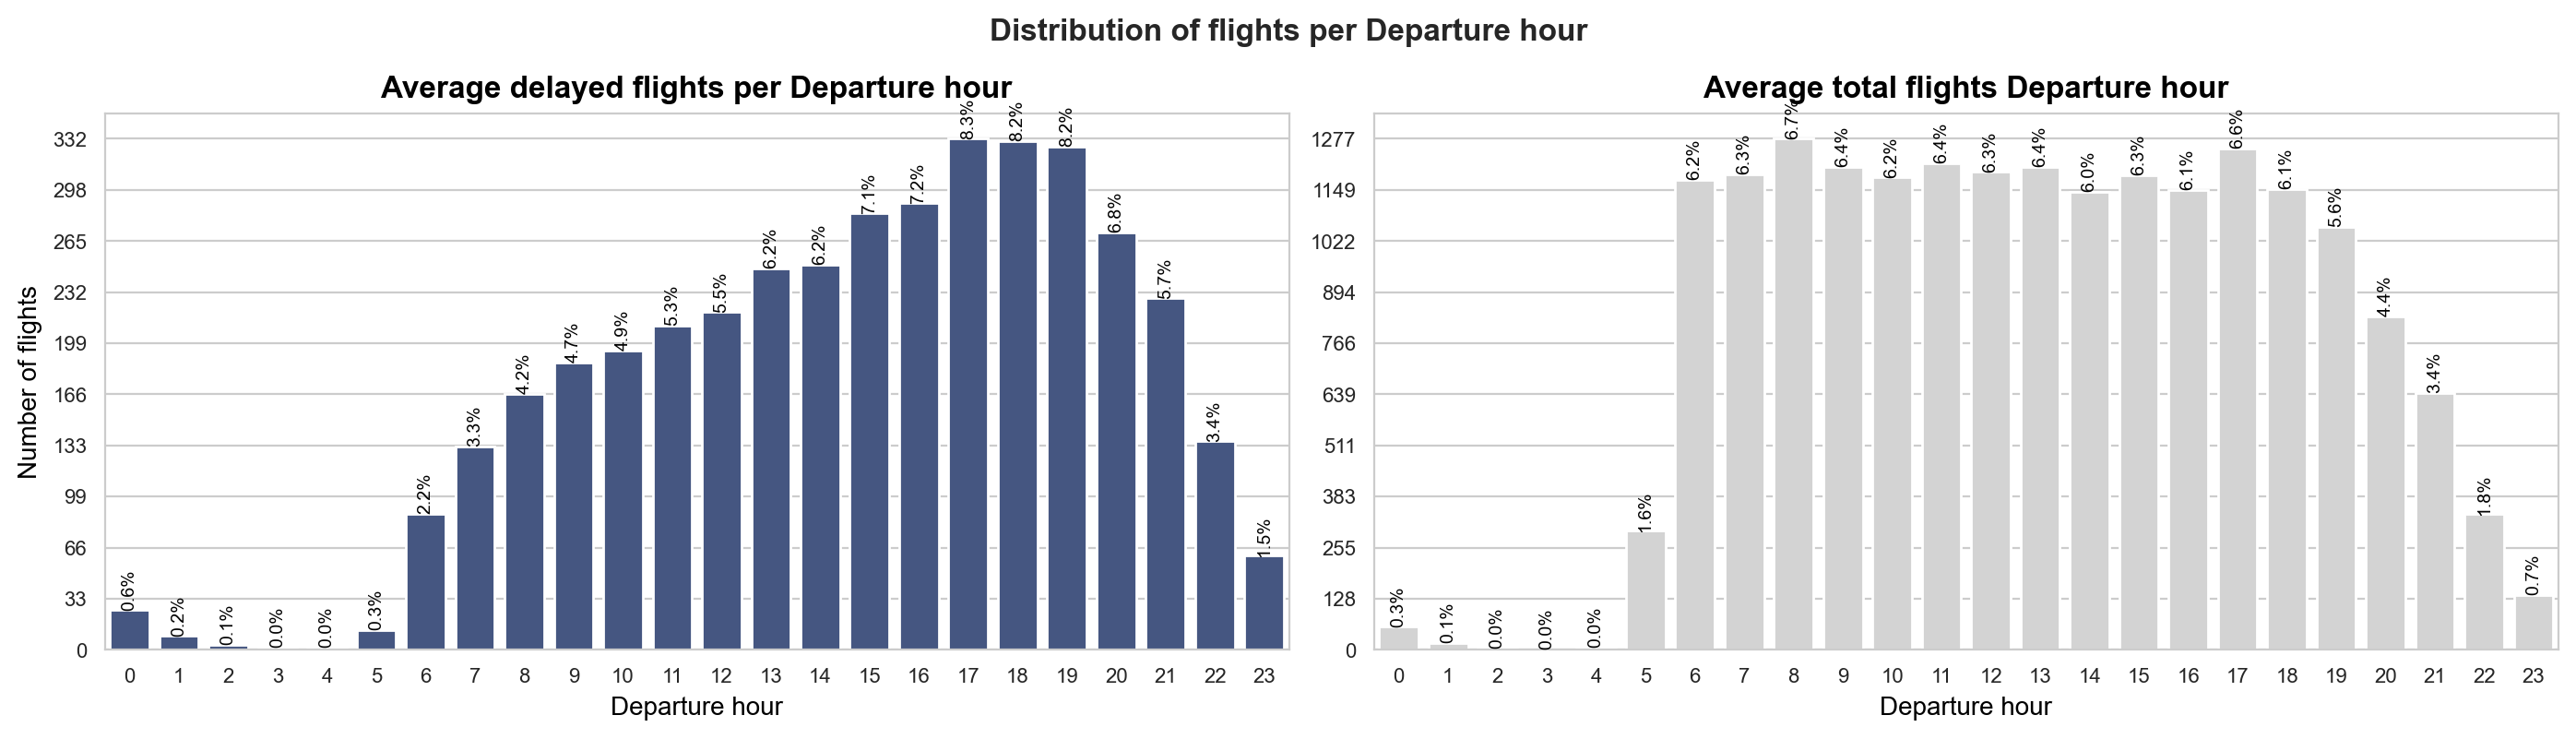

In [16]:
vs.plot_period_side_by_side(df=flight_timeseries_day, col=flight_timeseries_day.index.hour, annotate=True, title='Departure hour', rotate=True, sharey=False)

<div style="font-size: 14px;">
<strong>Conclusion:</strong>
Delays are growing progressively throughout the day starting at 6am until 8pm whereas the total number of flights stay constant. <strong>Delay peaks are between for 5-8pm</strong>. 
From 8pm, both the delays and number of flights decrease.
</div>

<span style="text-align: center; color:blue; font-size:30px; line-height:40px; font-family: Arial Black;">3. Carrier and Airport Analysis</span>

<span style="text-align: center; color:blue; font-size:20px; line-height:30px; font-family: Arial Black;">3.1 Busiest Departure Airports</span>

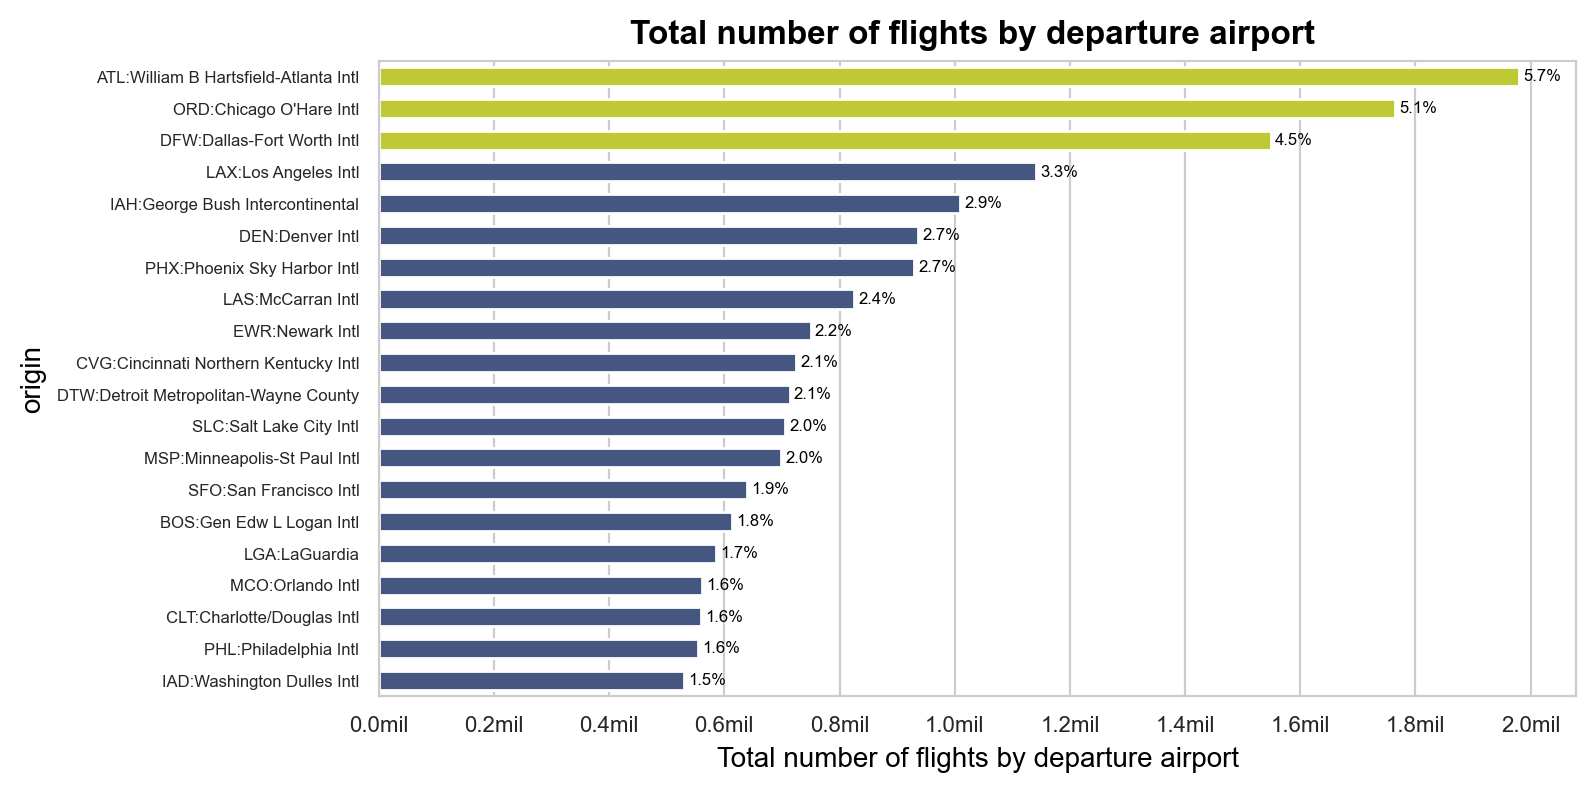

In [17]:
# plot total flight distribution by carrier
vs.flights_by_cat(df=flights, col='origin', title='Total number of flights by departure airport', lookup=True, df_lookup=airports, df_lookup_field='airport')

<div style="font-size: 14px;">
<strong>Conclusion:</strong>
<br>International airports in Atlanta (ATL), Chicago (ORD) and Dallas (DFW) are the busiest airports in the US, covering 15% of all flights
</div>

<span style="text-align: center; color:blue; font-size:20px; line-height:30px; font-family: Arial Black;">3.2 Busiest Departure Airports - How many flights are delayed ?</span>

<div style="font-size: 14px;">
International airports in Atlanta (ATL), Chicago (ORD) and Dallas (DFW) are the busiest airports in the US, covering 15% of all flights
</div>

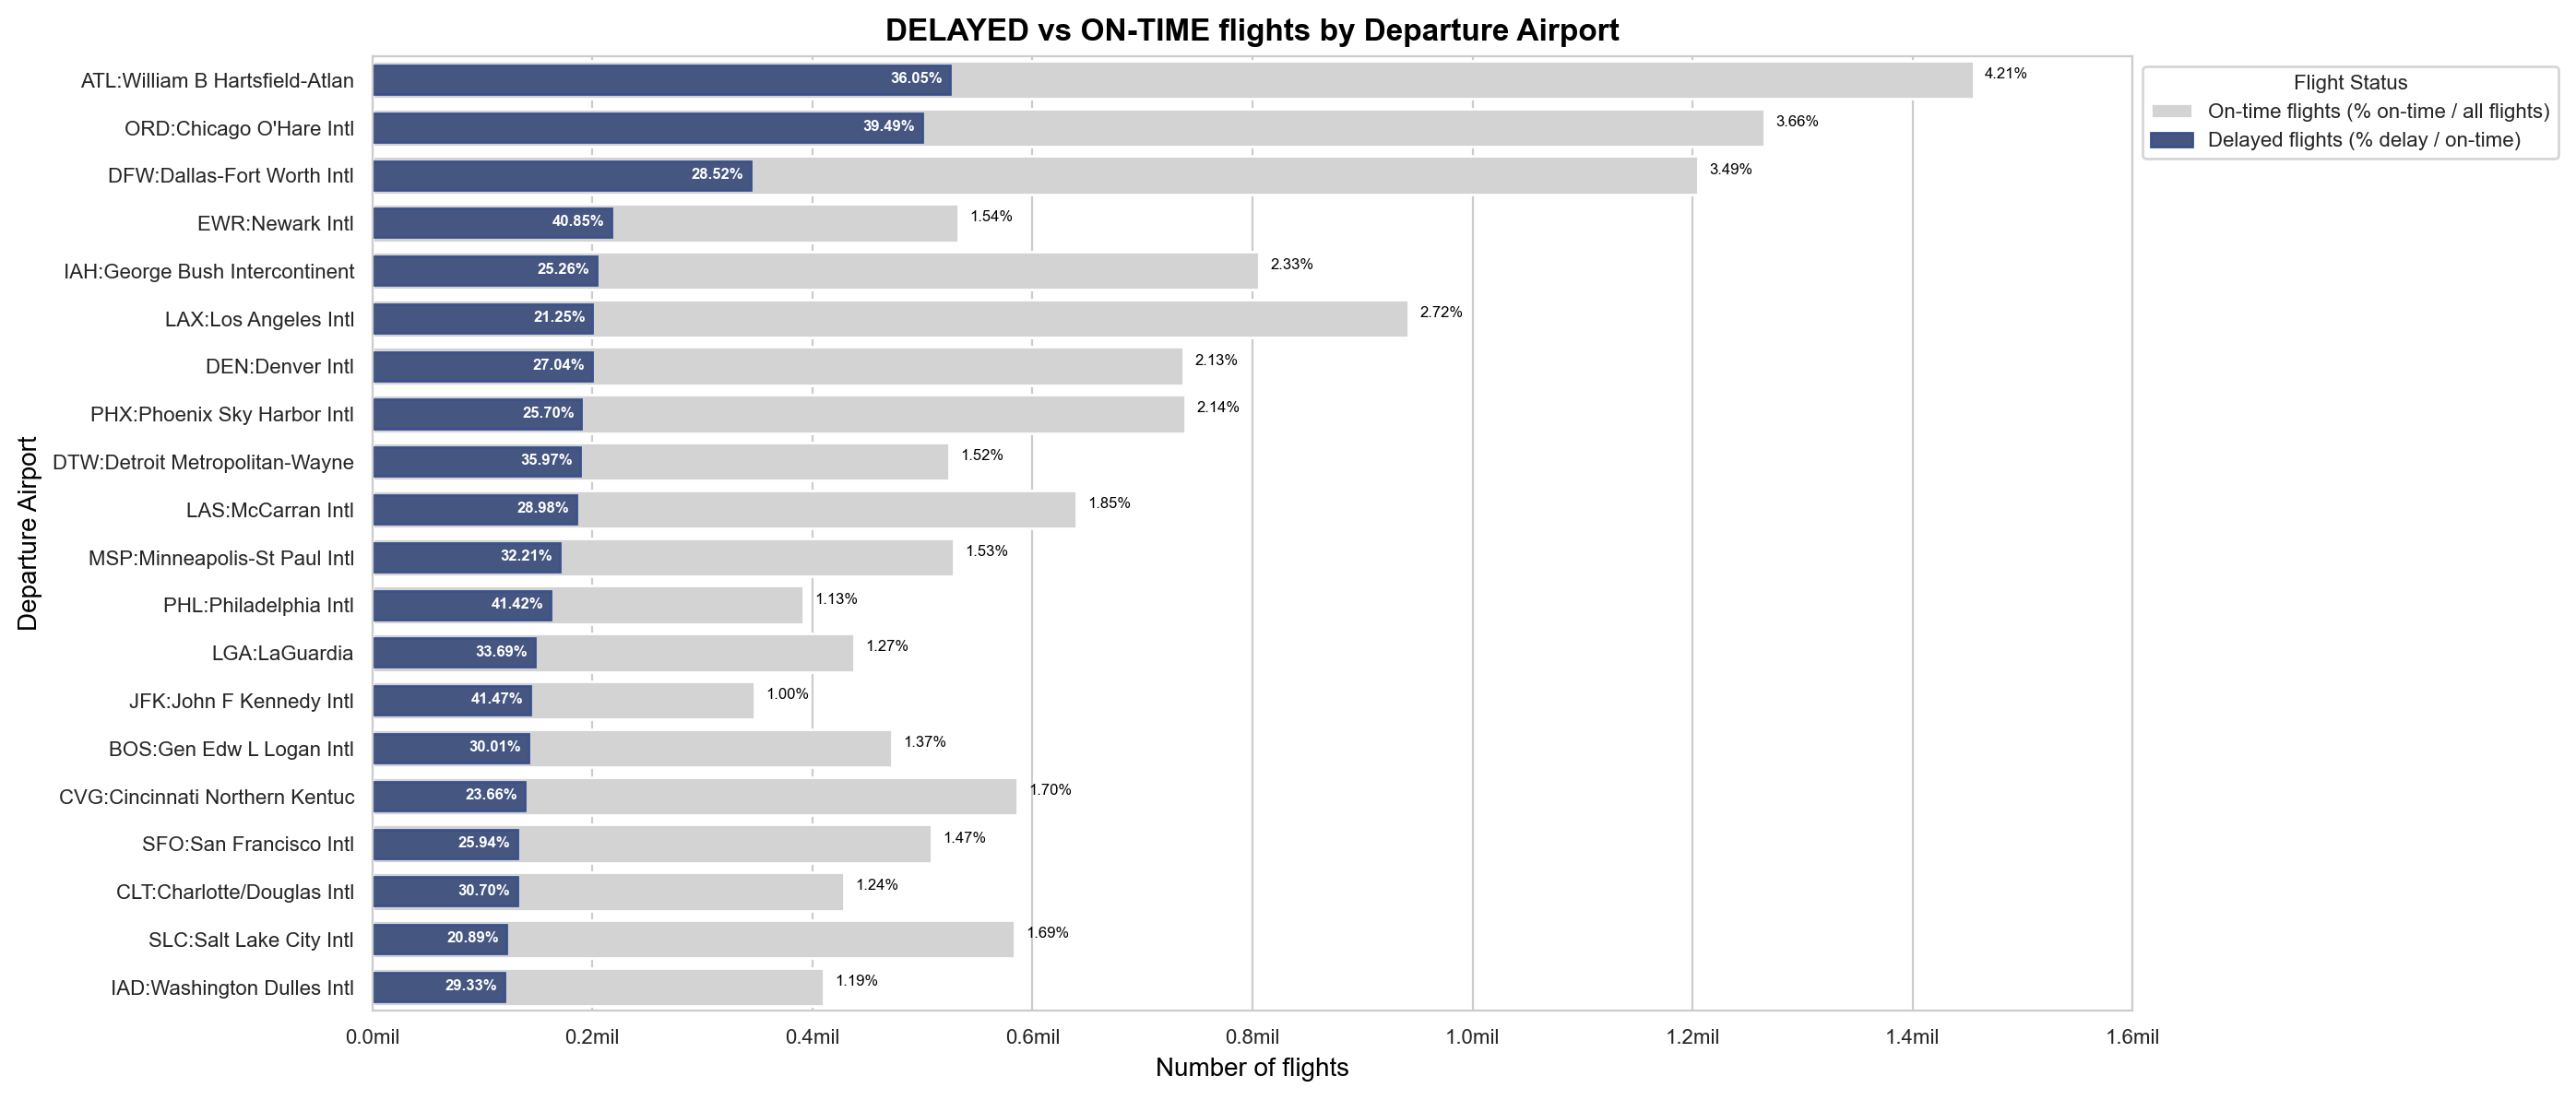

In [18]:
# plot proportion of delayed vs on-time flights for origin airports
origin = flights.groupby('origin')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
origin['airport'] = origin.index + ':' + airports.loc[origin.index]['airport']
origin.reset_index(inplace=True)
origin.set_index('airport', inplace=True)
origin['prop_delayed'] = origin['delayed'] / (origin['delayed'] + origin['on_time'])
vs.plot_categories(df=origin, title='Departure Airport', figsize=(14,6))

<div style="font-size: 14px;">
<strong>Conclusion:</strong><br>
From a proportional perspective, John F Kennedy (JFK), Philadelpha (PHL), Newark (EWR) and Chicago (ORD) have over 40% of their flights delayed on departure
</div>

<span style="text-align: center; color:blue; font-size:20px; line-height:30px; font-family: Arial Black;">3.3 Busiest Carriers</span>



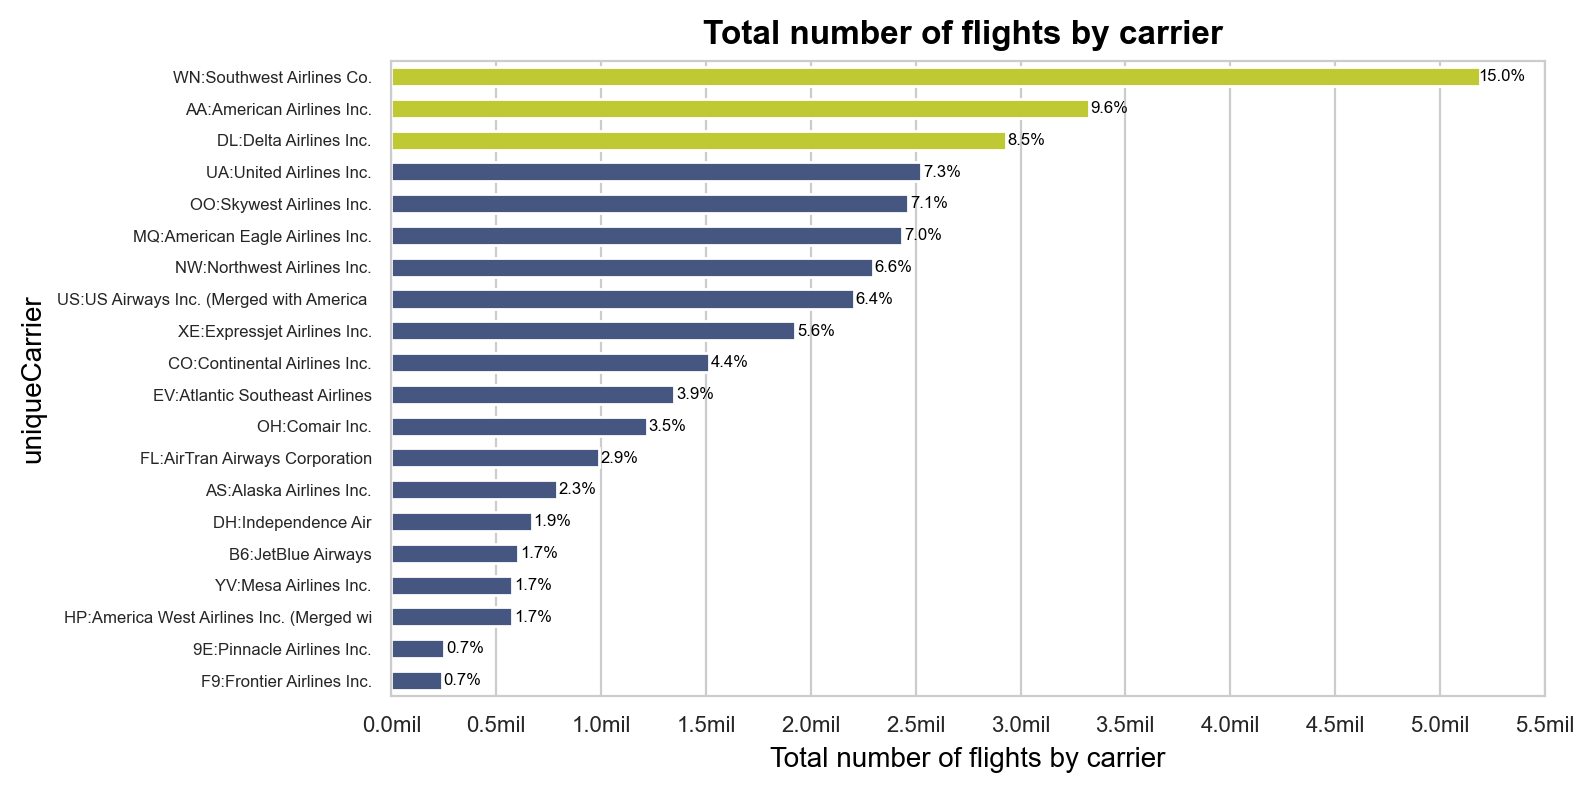

In [19]:
# plot flight distribution by carrier
vs.flights_by_cat(df=flights, col='uniqueCarrier', title='Total number of flights by carrier', lookup=True, df_lookup=carriers, df_lookup_field='carrier_description')

<div style="font-size: 14px;">
<strong>Conclusion:</strong><br>
Southwest Airlines (WN), Americal Airlines (AA) and Delta Airlines (DL) are the biggest airlines in US, covering 33% of all flights
</div>

<span style="text-align: center; color:blue; font-size:20px; line-height:30px; font-family: Arial Black;">3.4 Busiest Carriers - How many flights are delayed ?</span>

<div style="font-size: 14px;">
Southwest Airlines (WN), Americal Airlines (AA) and Delta Airlines (DL) are the biggest airlines in US, covering 33% of all flights
</div>

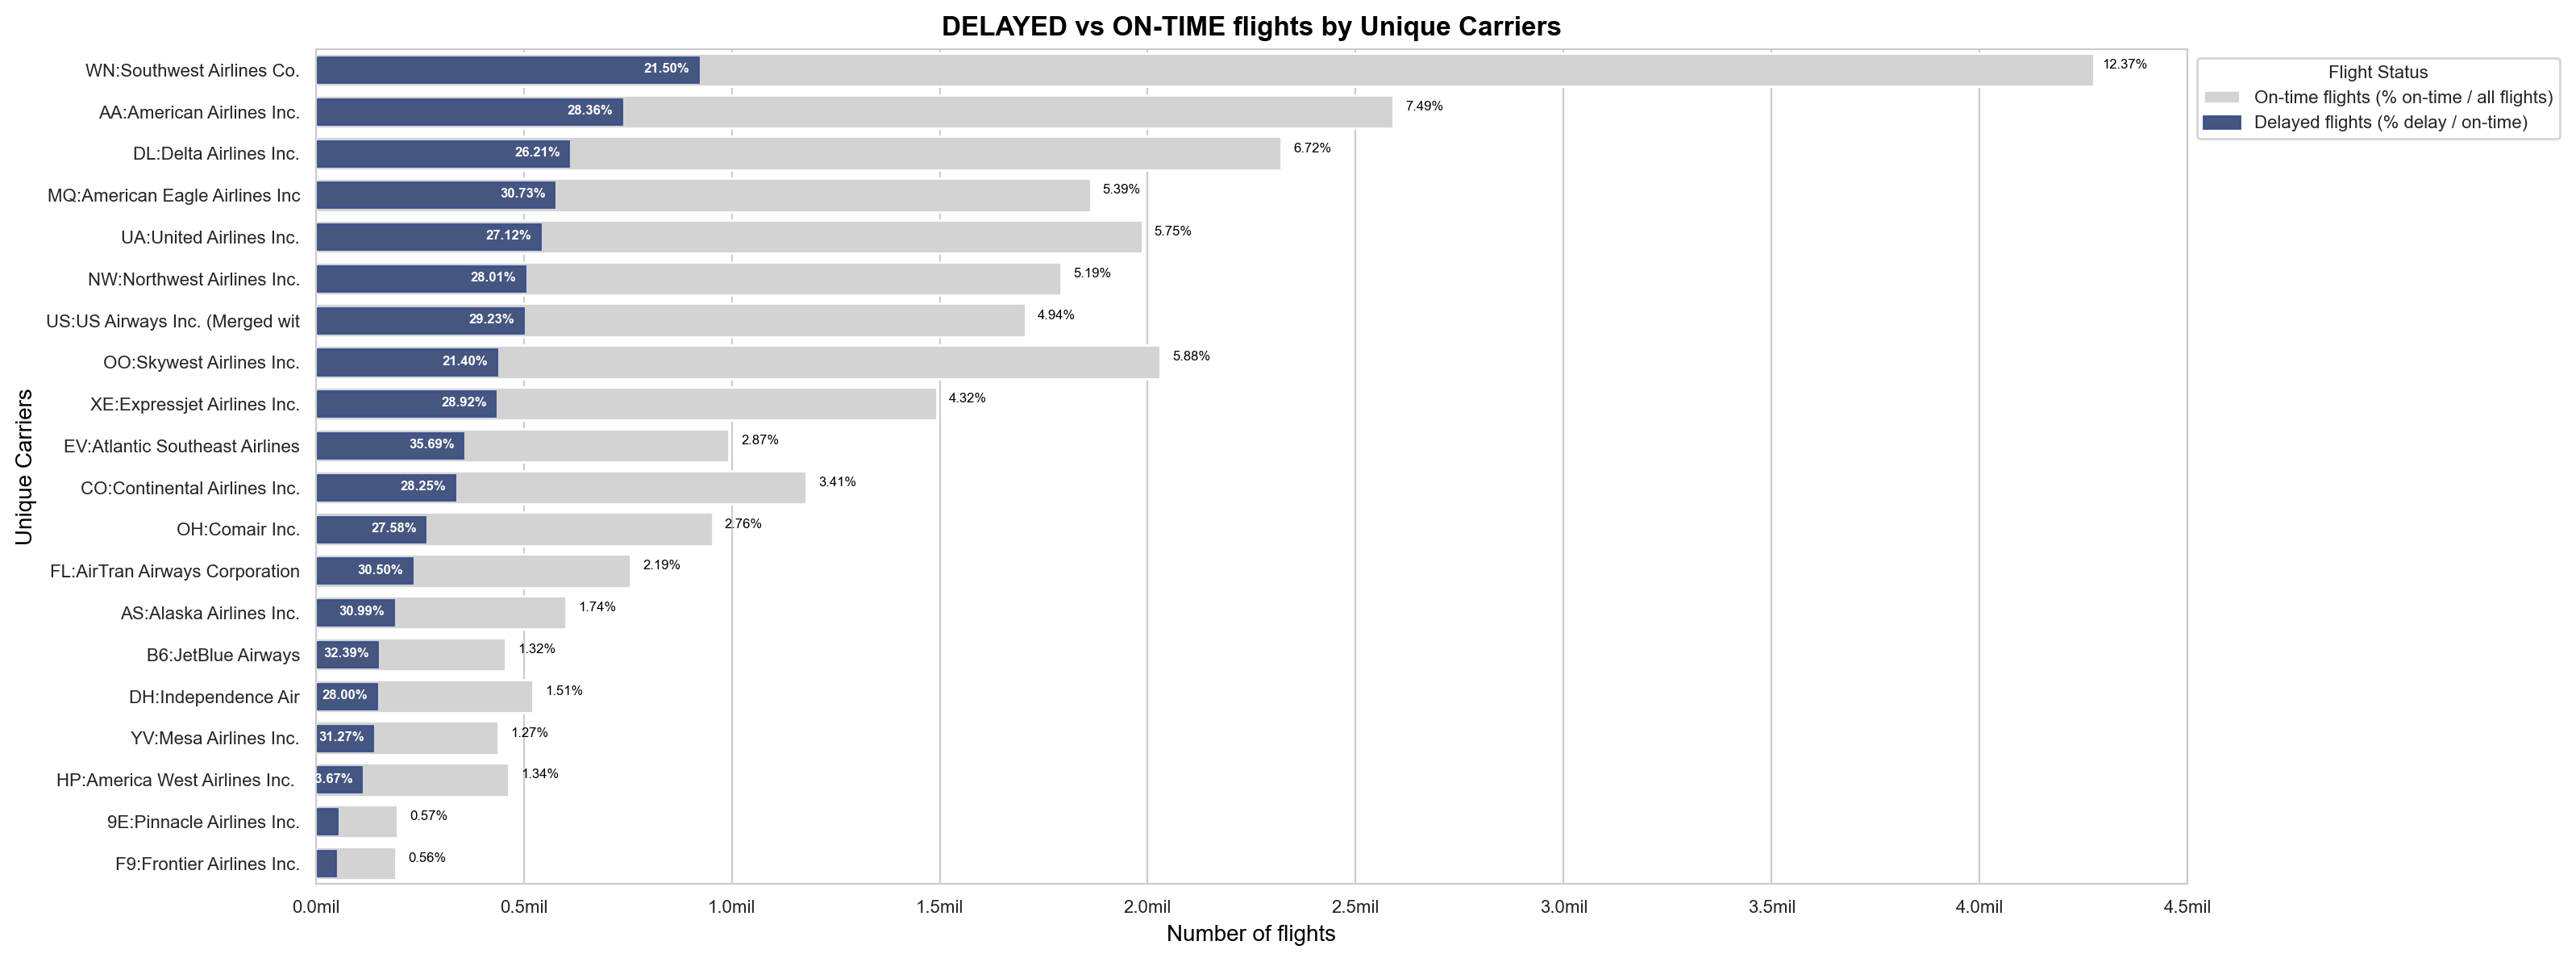

In [20]:
# plot distribution of delayed vs on-time flights by carrier
cat_carrier = flights.groupby('uniqueCarrier')['flight_status'].value_counts().unstack().sort_values(by='delayed', ascending=False)
cat_carrier['total_flights'] = cat_carrier.sum(axis=1).astype('int32')
cat_carrier = cat_carrier.merge(carriers, how='inner', on='uniqueCarrier')
cat_carrier = cat_carrier.reset_index()
cat_carrier['carrier'] = cat_carrier.uniqueCarrier + ':' + cat_carrier['carrier_description']
cat_carrier.set_index('carrier', inplace=True)
cat_carrier['prop_delayed'] = cat_carrier['delayed'] / (cat_carrier['delayed'] + cat_carrier['on_time'])
# cat_carrier_prop = cat_carrier.sort_values(by='prop_delayed', ascending=False)
vs.plot_categories(df=cat_carrier, title='Unique Carriers', topn=20, figsize=(16,6))

<div style="font-size: 12px;">
<strong>Conclusion:</strong><br>
        <br>Carriers with the most delayed flights from a proportional perspective:<br>
                <ol>
                <li>EV: Atlantic Southeast (36%)</li>
                <li>B6: Jet Blue (32%)</li>
                <li>YV: Mesa Airlines (31%)</li>
                <li>MQ: Americaln Eagle (31%) </li>
                </ol>
</div>

In [21]:
# get top 30 carriers causing delays
top_carrier = list(cat_carrier['uniqueCarrier'][:20])

# get top departure airports causing delays
top_origin = list(origin['origin'][:20])

# filter flights dataset on the top 30 airports and carriers causing the most delays
df_heatmap_top30 = flights[['uniqueCarrier', 'origin', 'lane', 'depDelay', 'carrierDelay', 'lateAircraftDelay', 'NASDelay']].copy()
df_heatmap_top30 = df_heatmap_top30.loc[(df_heatmap_top30['uniqueCarrier'].isin(top_carrier))]
df_heatmap_top30 = df_heatmap_top30.loc[(df_heatmap_top30['origin'].isin(top_origin))]

# Focus only on frequent flying carrier/origin combinations where number of flights exceed at least 200 for the 4 year period
df_heatmap_exclude = df_heatmap_top30.groupby(['uniqueCarrier', 'origin']).size().reset_index().rename(columns={0:'count'})
df_heatmap_exclude = df_heatmap_exclude[df_heatmap_exclude['count'] < 200]

df_heatmap_top30 = pd.merge(df_heatmap_top30, df_heatmap_exclude, on=['uniqueCarrier', 'origin'], how='outer', indicator=True)
df_heatmap_top30 = df_heatmap_top30.loc[df_heatmap_top30['_merge'] == 'left_only'].drop(['_merge', 'count'], axis=1)

# create heatmap of carriers and departure airports
df_heatmap_depDelay = df_heatmap_top30.pivot_table(values='depDelay',index='uniqueCarrier',columns='origin', aggfunc=np.mean, sort=False)

# first reorder origin airports from low to high mean delays
df_heatmap_depDelay = df_heatmap_depDelay.loc[:, df_heatmap_depDelay.max().sort_values().index]

# then reorder carriers from low to high mean delays
df_heatmap_depDelay = df_heatmap_depDelay.loc[df_heatmap_depDelay.max(axis=1).sort_values().index, :]

<span style="text-align: center; color:blue; font-size:20px; line-height:30px; font-family: Arial Black;">3.5 Average delay by Carrier and the Departure Airport</span>
<div style="font-size: 14px;">
All airports and carriers will have delays during seasonal peaks, however certain airports and carriers have delays above average
</div>

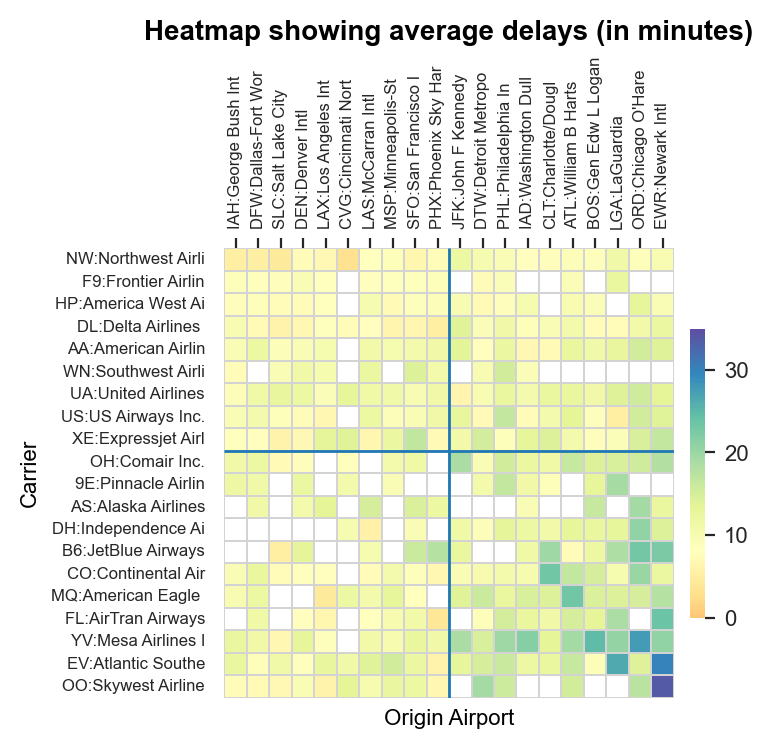

In [22]:
# plot carrier/departure airport heatmap
plt.figure(figsize = [4,4])

g = sns.heatmap(df_heatmap_depDelay, center=8, cmap='Spectral', linewidths=0.1, linecolor='lightgrey', square=True, mask=df_heatmap_depDelay <= 0, 
                annot=False, fmt=".0f", vmax=35, vmin=0, cbar_kws={"orientation": "vertical", "pad": 0.03, "shrink": 0.5})

# add descriptions to xticks
xticks = g.get_xticks()
xlabels = []
locs, labels = plt.xticks()
for loc, label in zip(locs,labels):  
    city = '{}:{}'.format(label.get_text(), airports.loc[label.get_text()]['airport'][:15])
    xlabels.append(city)
plt.xticks(xticks, xlabels, rotation=90, fontsize=6)

# add descriptions to yticks
yticks = g.get_yticks()
ylabels = []
locs, labels = plt.yticks()
for loc, label in zip(locs,labels):  
    carrier = '{}:{}'.format(label.get_text(), carriers.loc[label.get_text()]['carrier_description'][:15])
    ylabels.append(carrier)
plt.yticks(yticks, ylabels, rotation=360, fontsize=6)

# put xlabels on top
plt.title('Heatmap showing average delays (in minutes)', fontsize=10)
g.set(xlabel=" ", ylabel=" ")
g.xaxis.tick_top()

# divide heatmap into quadrants so the bottom right quadrant stands out more clearly
g.hlines([9], *g.get_xlim(), linewidth=1)
g.vlines([10], *g.get_ylim(), linewidth=1)

# add arrow to heatmap to point out the problem area where most delays exist
# t = g.text(30, 25, "Problem quadrant",
#             ha="center", va="center", rotation=-180, size=9,
#             bbox=dict(boxstyle="rarrow,pad=0.2",
#                       fc="lightblue", ec="steelblue", lw=1))

plt.xlabel('Origin Airport', fontsize=8)
plt.ylabel('Carrier', fontsize=8)
plt.tight_layout()
plt.show()

<div style="font-size: 10px"> 
<strong>Conclusion:</strong>
<ul>
<li>The bottom right quadrant (<strong>problem quandrant</strong>) contains the carriers and airport combinations with the most average delays, the <strong>darker green/blue area is clearly distinguishable</strong>.</li>
    <li>The top 3 biggest carriers <strong>(WN, AA, DL)</strong> have below average but consistant delays across all airports and appear in the <strong>top half of the heatmap</strong></li>
<li>3 of the businest departure airports <strong>(ATL, ORD, EWR)</strong> are positioned on the <strong>right of the heatplot</strong>. However these airports are not doing consistantly 'bad', carriers in the <strong>top half</strong> are still doing well at these airports.</li></ul>  
<br><br>The fact that the same carriers does well at airports in left quadrants, but worse at airports in the right quadrants, indicate there is something specific about the carrier/location relationship we should explore further 
</div> 

<span style="text-align: center; color:blue; font-size:30px; line-height:40px; font-family: Arial Black;">4. What are the reasons for higher than average delays in the problem quadrant ?</span>

<div style="font-size: 12px;">
Why are certain carriers performing bad only at certain airports ?


<br> Problem quadrant is highlighted in red

</div>
    
<!-- <img src="../images/heatmap.png" alt="drawing" width=400 heigh=400 align='left'/>     -->

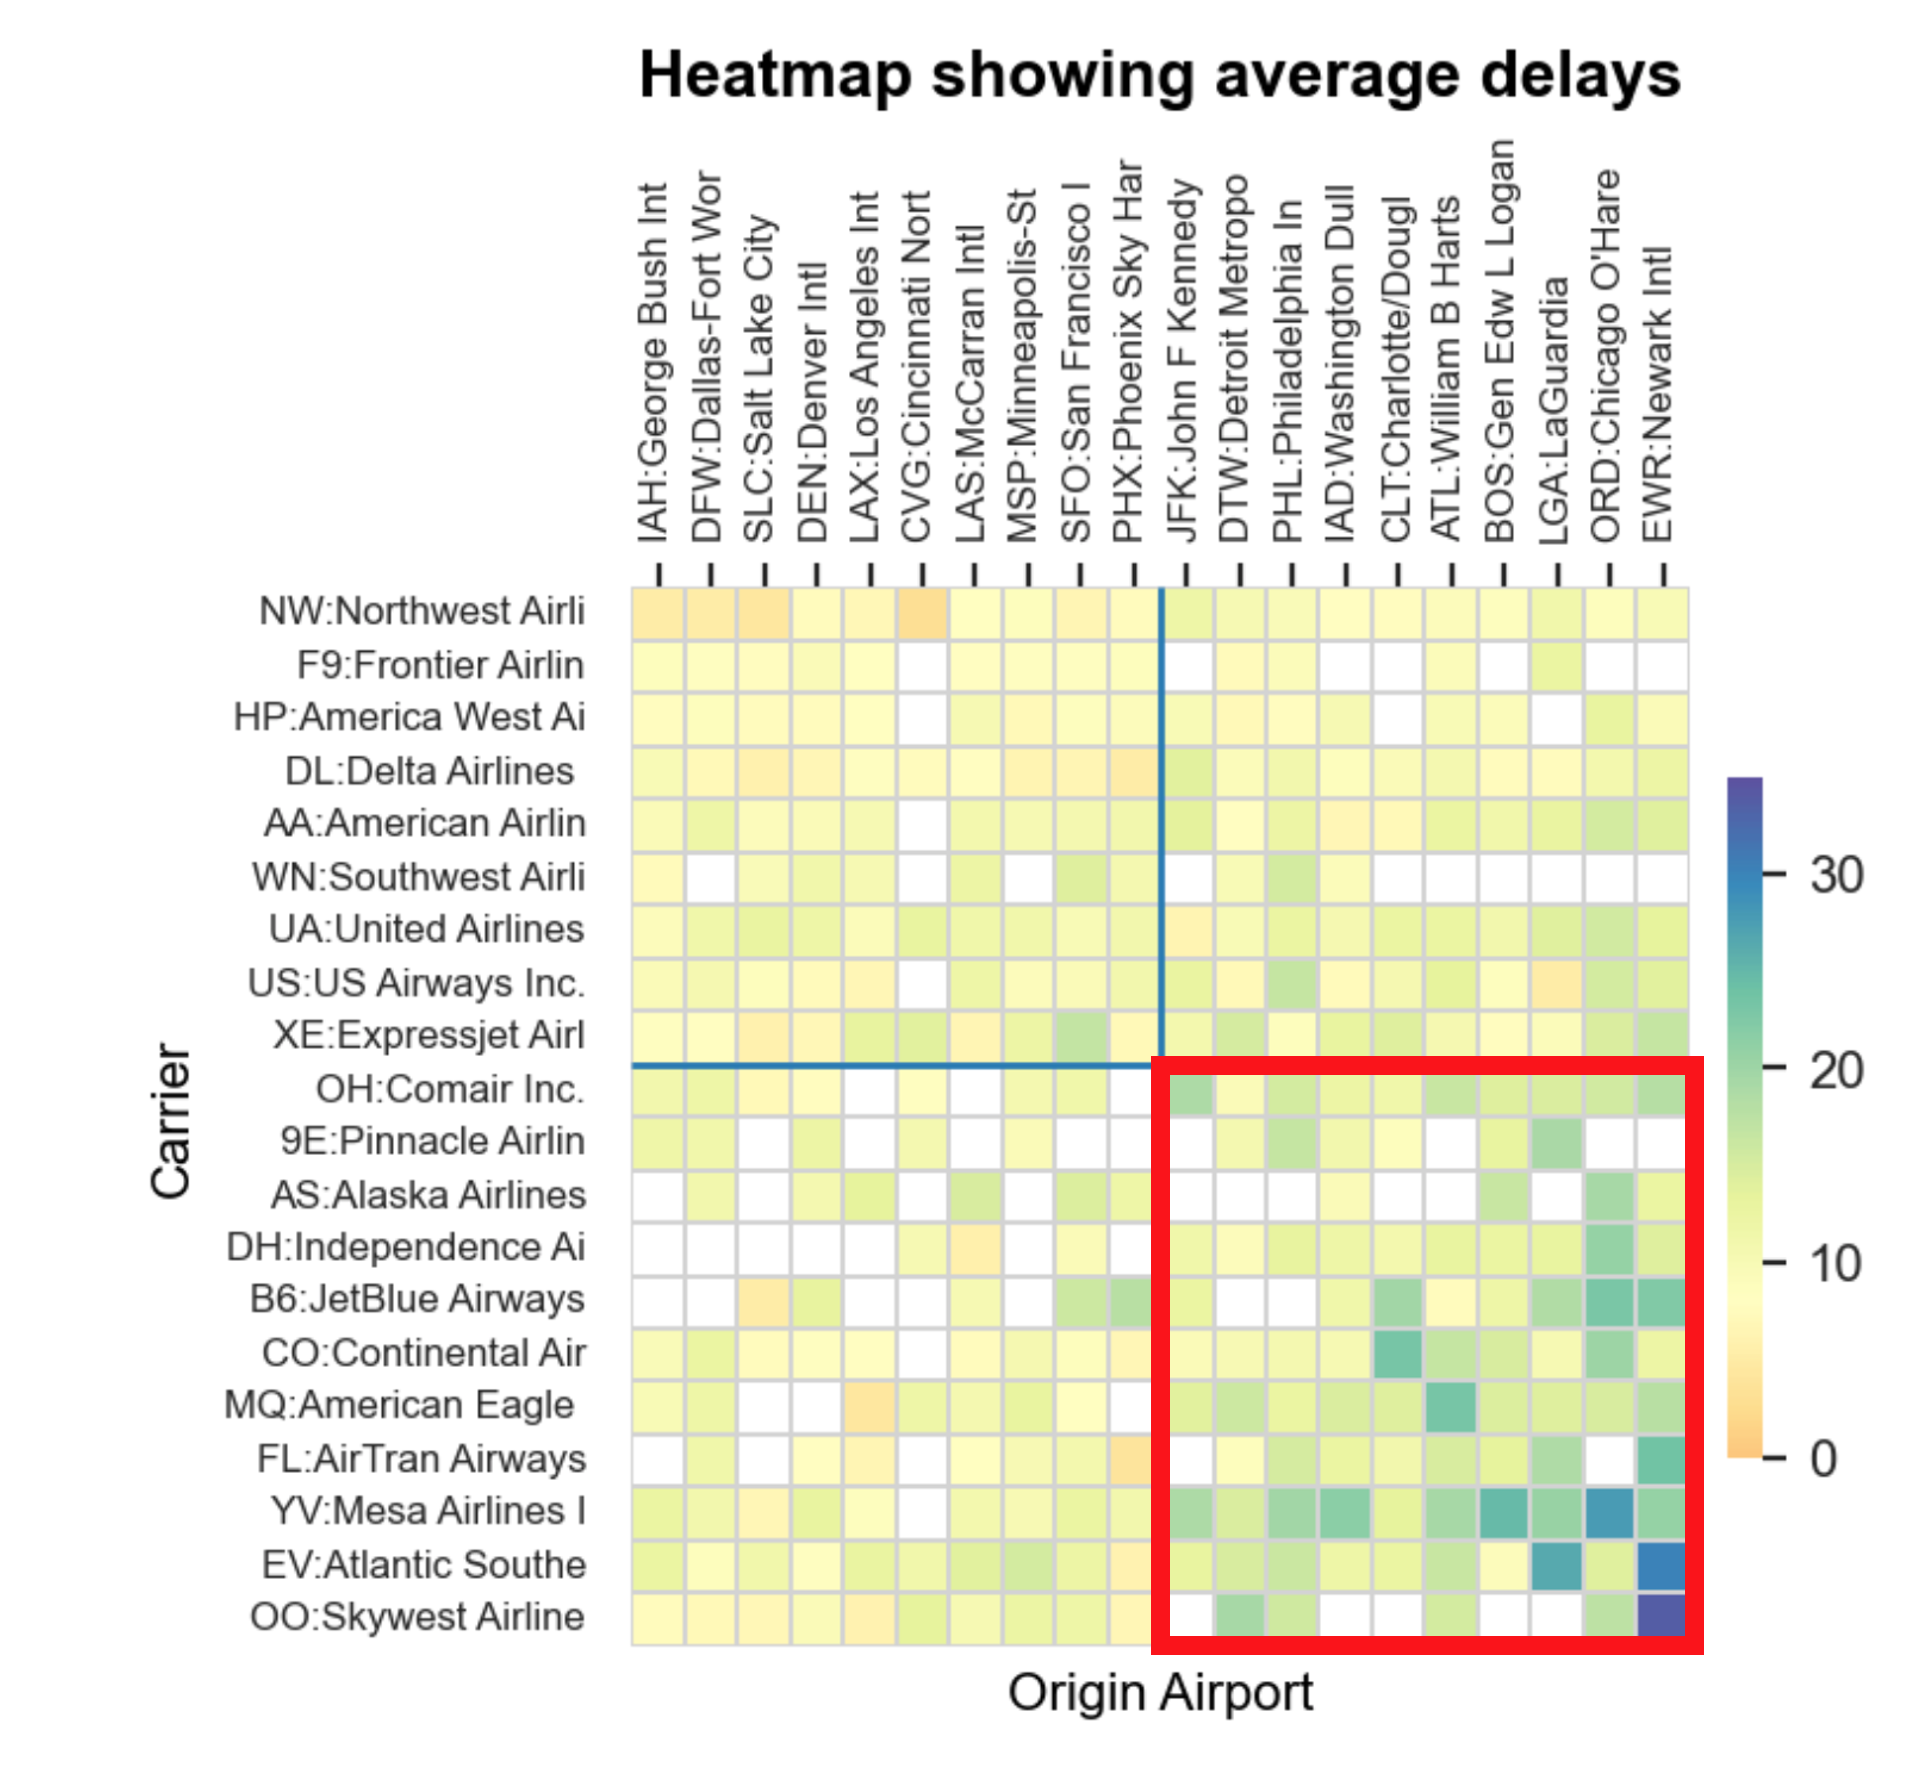

In [44]:
display(Image(filename="../images/heatmap.png", width=300))

In [23]:
# select the 'best' and 'worse' carrier/airport combinations in the same sequence as in heatmap, so we can compare them
# for 'best', select the 4 largest airlines that does well accross all airports

# get the carriers and airports combinations in the same sequence as in heatmap, from low to high average total delays
problem_carrier = [label.split(':')[0] for label in ylabels] 
problem_airport = [label.split(':')[0] for label in xlabels] 
problem_carrier_description = ylabels
problem_airport_description = xlabels 

topn_best_worse = 8
problem_carrier_best_worse = problem_carrier[2:6] + problem_carrier[topn_best_worse*-1:] 
problem_airport_best_worse = problem_airport[2:6] + problem_airport[topn_best_worse*-1:]  
problem_carrier_description_best_worse = ylabels[2:6] + ylabels[topn_best_worse*-1:]
problem_airport_description_best_worse = xlabels[2:6] + xlabels[topn_best_worse*-1:]

# create dataset with best and worse carrier/airport combinations using heatmap above as base
df_heatmap_topn_best_worse = df_heatmap_top30[['uniqueCarrier', 'origin', 'carrierDelay', 'lateAircraftDelay', 'NASDelay']].copy()
df_heatmap_topn_best_worse = df_heatmap_topn_best_worse.loc[(df_heatmap_topn_best_worse['uniqueCarrier'].isin(problem_carrier_best_worse))]
df_heatmap_topn_best_worse = df_heatmap_topn_best_worse.loc[(df_heatmap_topn_best_worse['origin'].isin(problem_airport_best_worse))]

# aggregate new datasets from different angles to analyze reason for delays
f = {'carrierDelay':np.mean, 'lateAircraftDelay':np.mean, 'NASDelay':np.mean}
df_heatmap_topn_best_worse = df_heatmap_topn_best_worse.groupby(['uniqueCarrier', 'origin'], as_index=False).agg(f)

<span style="text-align: center; color:blue; font-size:20px; line-height:30px; font-family: Arial Black;">4.1 Reasons for delays</span>

<div style="font-size: 14px;">
Why are certain carriers performing bad only at certain airports ?

<br>The 4 biggest airlines (HP, DL, AA, WN) that does consistently well at all airports, are compared with the 8 worse performing carriers from the <em>problem quadrant</em>

</div>

<div style="font-size: 12px;">
(Same color coding from heatmap is used: yellow/light green represent good, darkgreen/blue present bad)
</div>

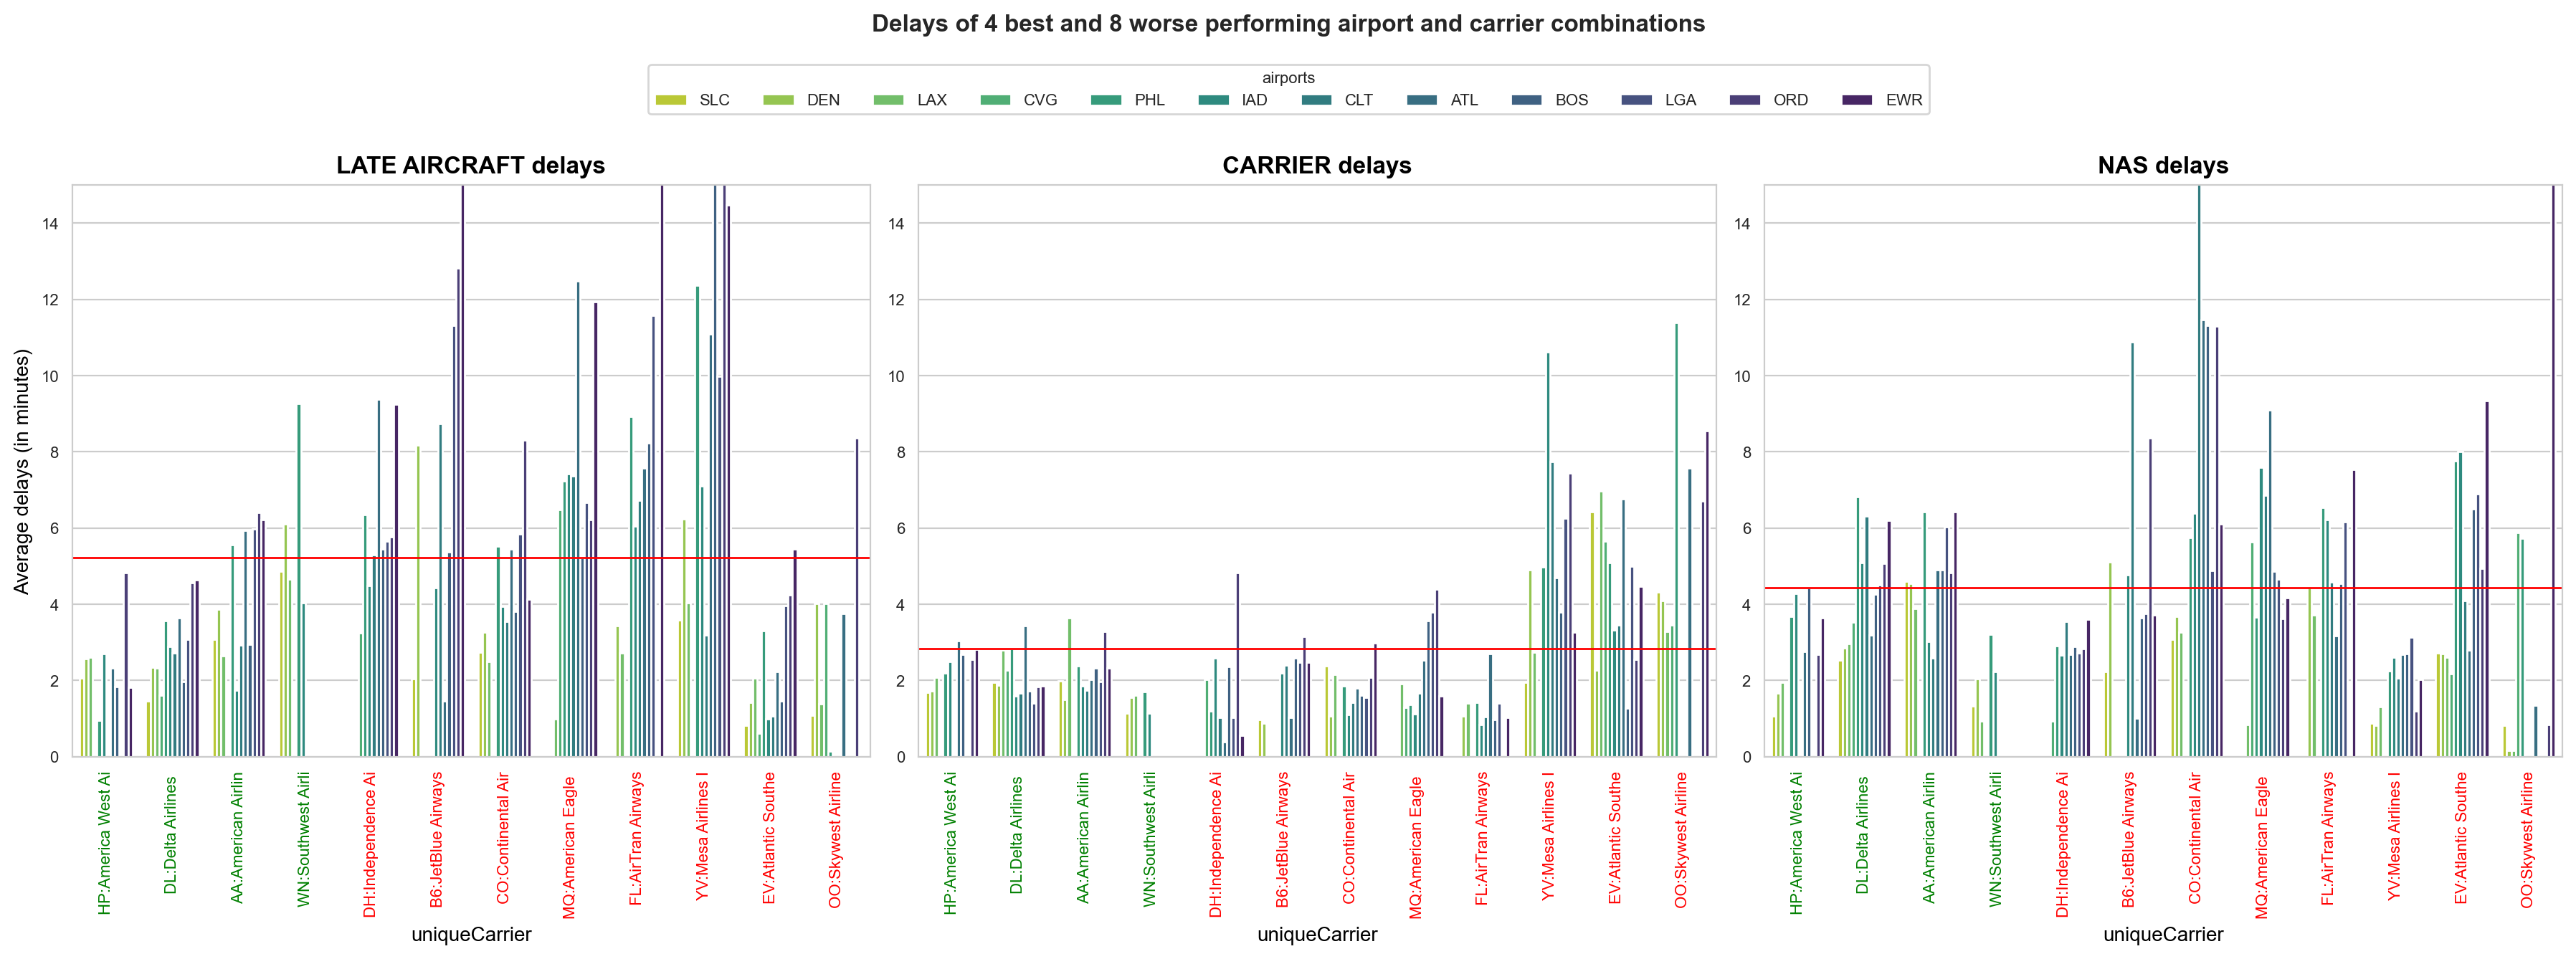

In [24]:
plt.figure(figsize = [18,6])

ax1 = plt.subplot(1,3,1)
sns.barplot(data=df_heatmap_topn_best_worse, x='uniqueCarrier', y='lateAircraftDelay', hue='origin', order=problem_carrier_best_worse, hue_order=problem_airport_best_worse, 
            palette='viridis_r')
plt.axhline(y=df_heatmap_topn_best_worse['lateAircraftDelay'].mean(), color='r', linewidth=1)
plt.ylabel('Average delays (in minutes)')
xticks = ax1.get_xticks()
# ax1.tick_params(axis='x', colors=['red', 'blue'])
plt.xticks(xticks, problem_carrier_description_best_worse, rotation=90)
plt.title('LATE AIRCRAFT delays')
plt.figlegend(bbox_to_anchor=(0.5, 1.05), loc = 'upper center', title='airports', fancybox=True, ncol=len(problem_airport_best_worse))
plt.legend().set_visible(False)
plt.ylim(0,15)

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')


plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
sns.barplot(data=df_heatmap_topn_best_worse, x='uniqueCarrier', y='carrierDelay', hue='origin', order=problem_carrier_best_worse, hue_order=problem_airport_best_worse, palette='viridis_r')
plt.axhline(y=df_heatmap_topn_best_worse['carrierDelay'].mean(), color='r', linewidth=1)
plt.legend().set_visible(False)
plt.ylabel('')
plt.xticks(xticks, problem_carrier_description_best_worse, rotation=90)
plt.title('CARRIER delays')

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')


plt.subplot(1,3,3, sharex=ax1, sharey=ax1)
sns.barplot(data=df_heatmap_topn_best_worse, x='uniqueCarrier', y='NASDelay', hue='origin', order=problem_carrier_best_worse, hue_order=problem_airport_best_worse, palette='viridis_r')
plt.axhline(y=df_heatmap_topn_best_worse['NASDelay'].mean(), color='r', linewidth=1)
plt.ylabel('')
plt.xticks(xticks, problem_carrier_description_best_worse, rotation=90)
plt.title('NAS delays')
plt.legend().set_visible(False)

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')

plt.suptitle('Delays of 4 best and 8 worse performing airport and carrier combinations', y=1.1)

plt.tight_layout()
plt.show()

<div style="font-size: 14px"> 
<strong>Conclusion:</strong>
<br>Generally carriers on the right of the bar chart (from the problem quadrant) have above average delays across all delay reasons in multiple airports
</div>

In [25]:
# get flights for the top 10 worse performing carriers, and selected carriers that is doing well overall as comparision
flight_stats = flights.loc[(flights['uniqueCarrier'].isin(problem_carrier_best_worse)) & (flights['origin'].isin(problem_airport_best_worse))]

In [26]:
# calculate the distance, number of flights and avg delay per lane/carrier
flight_stats2 = flight_stats.groupby(['origin', 'lane', 'uniqueCarrier'], as_index=False).agg(depDelay=('depDelay', np.mean),
                                                                                              arrDelay=('arrDelay', np.mean), 
                                                                                              nrFlights=('lane', np.size),
                                                                                              distance=('distance', np.mean))
# analyse only frequent flights
flight_stats2 = flight_stats2.loc[flight_stats2['nrFlights'] >= 300]

In [27]:
# calculate avg flights per day (fpd) per lane
flight_stats_fpd = flight_stats.groupby(['lane', 'uniqueCarrier', 'year', 'month', 'day'], as_index=False).size()
flight_stats_fpd['size'] = flight_stats_fpd['size'].round(0)
flight_stats_fpd = flight_stats_fpd.loc[flight_stats_fpd['size'] >= 1]
flight_stats_fpd = flight_stats_fpd.groupby(['lane', 'uniqueCarrier'], as_index=False).agg(dailyFlights=('size', np.mean))

In [28]:
# merge datasets
flight_stats_final = pd.merge(flight_stats2, flight_stats_fpd, on=['lane', 'uniqueCarrier'], how='inner')
flight_stats_final.sort_values(by='dailyFlights', inplace=True)
flight_stats_final['dailyFlights'] = round(flight_stats_final['dailyFlights'],0)

# get carrier description
flight_stats_final = flight_stats_final.merge(carriers, how='inner', on='uniqueCarrier')
flight_stats_final['carrier_description'] = flight_stats_final.uniqueCarrier + ':' + flight_stats_final['carrier_description']
flight_stats_final.head()

origin     lane uniqueCarrier   depDelay   arrDelay  nrFlights  distance  \
0    IAD  IAD-SAN            B6  11.731049  12.426791        963    2253.0   
1    BOS  BOS-SJC            B6   9.535484  10.134409        930    2689.0   
2    BOS  BOS-SEA            B6  14.366796  16.247105        777    2496.0   
3    SLC  SLC-JFK            B6   4.451703   5.812953       1791    1989.0   
4    BOS  BOS-RDU            B6   7.583721   8.932558        430     612.0   

   dailyFlights carrier_description  
0           1.0  B6:JetBlue Airways  
1           1.0  B6:JetBlue Airways  
2           1.0  B6:JetBlue Airways  
3           1.0  B6:JetBlue Airways  
4           1.0  B6:JetBlue Airways

<span style="text-align: center; color:blue; font-size:20px; line-height:30px; font-family: Arial Black;">4.2 Repetitive short-haul flights</span>

<div style="font-size: 14px;">
Why are certain carriers performing bad only at certain airports ?
    
<br>Could it be that these carriers do repetitive short haul flights, and a delay in one leg, cause delays for the rest of the day?   
</div>

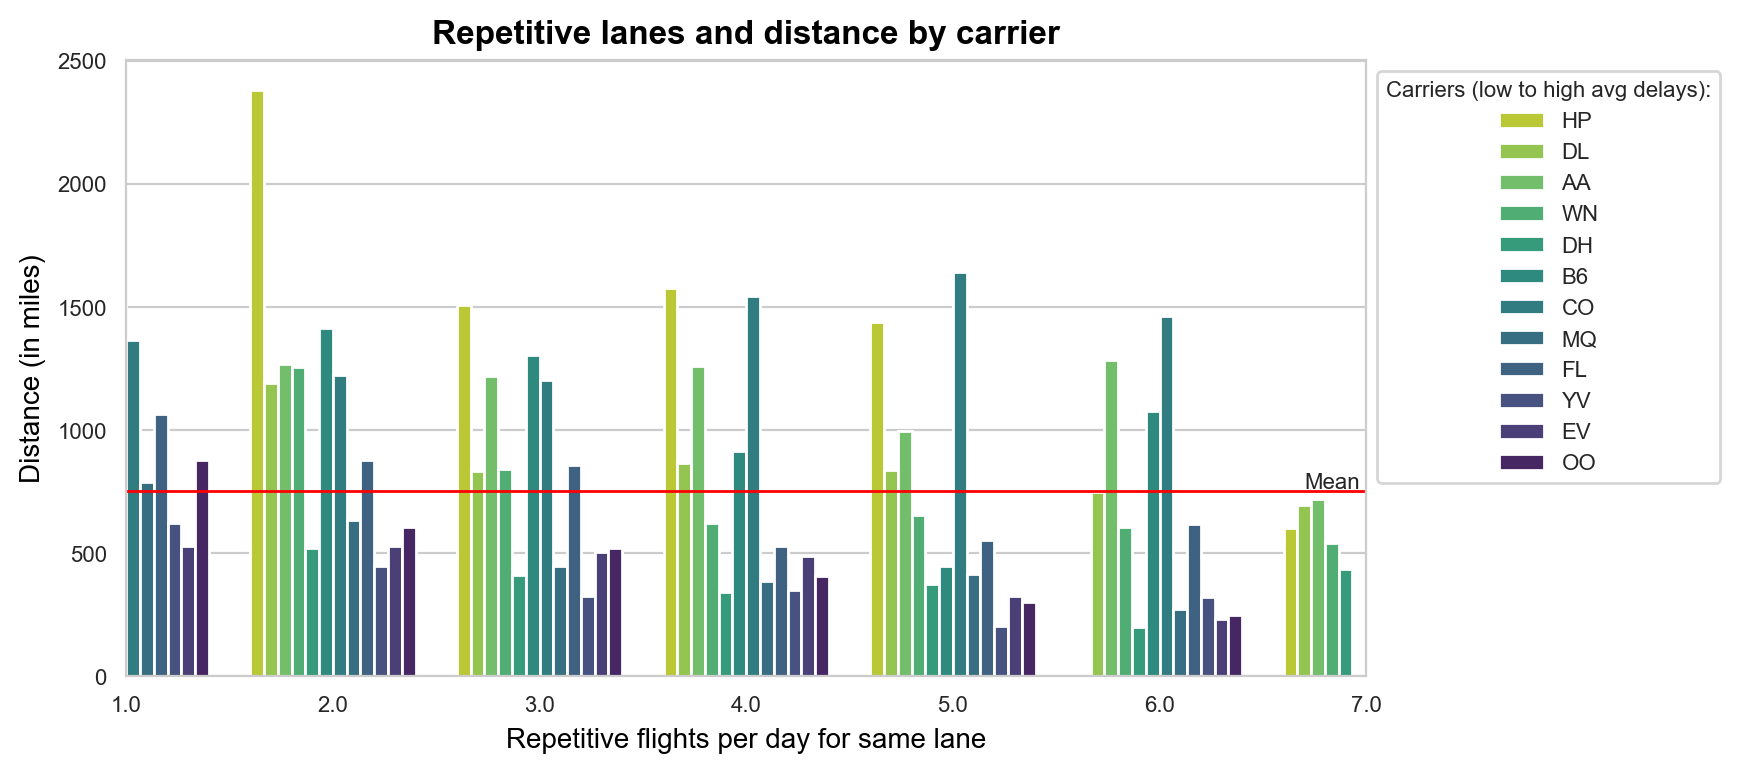

In [29]:
mean_distance = int(flight_stats_final['distance'].mean())

sns.barplot(data=flight_stats_final, x='dailyFlights', y='distance', hue='uniqueCarrier', linewidth=1, errorbar=None, hue_order=problem_carrier_best_worse, palette='viridis_r')
plt.axhline(y=mean_distance, color='r', linewidth=1)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Carriers (low to high avg delays):')
plt.xlim(0,6)

min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.95, mean_distance*1.01, 'Mean')

plt.title('Repetitive lanes and distance by carrier')
plt.ylabel('Distance (in miles)')
plt.xlabel('Repetitive flights per day for same lane')
plt.show()

<div style="font-size: 14px"> 
<strong>Conclusion:</strong>
<br>Carriers in the problem quadrant (dark green/blue bars on the right) fly multiple but shorter distances <= 500 miles, were carriers on the left of the quandrant (yellow/light green bars on the left), do distances near or above 1000 miles

<span style="text-align: center; color:blue; font-size:20px; line-height:30px; font-family: Arial Black;">4.3 Average flight distance by carrier</span>

<div style="font-size: 14px;">
Why are certain carriers performing bad only at certain airports ?
</div>

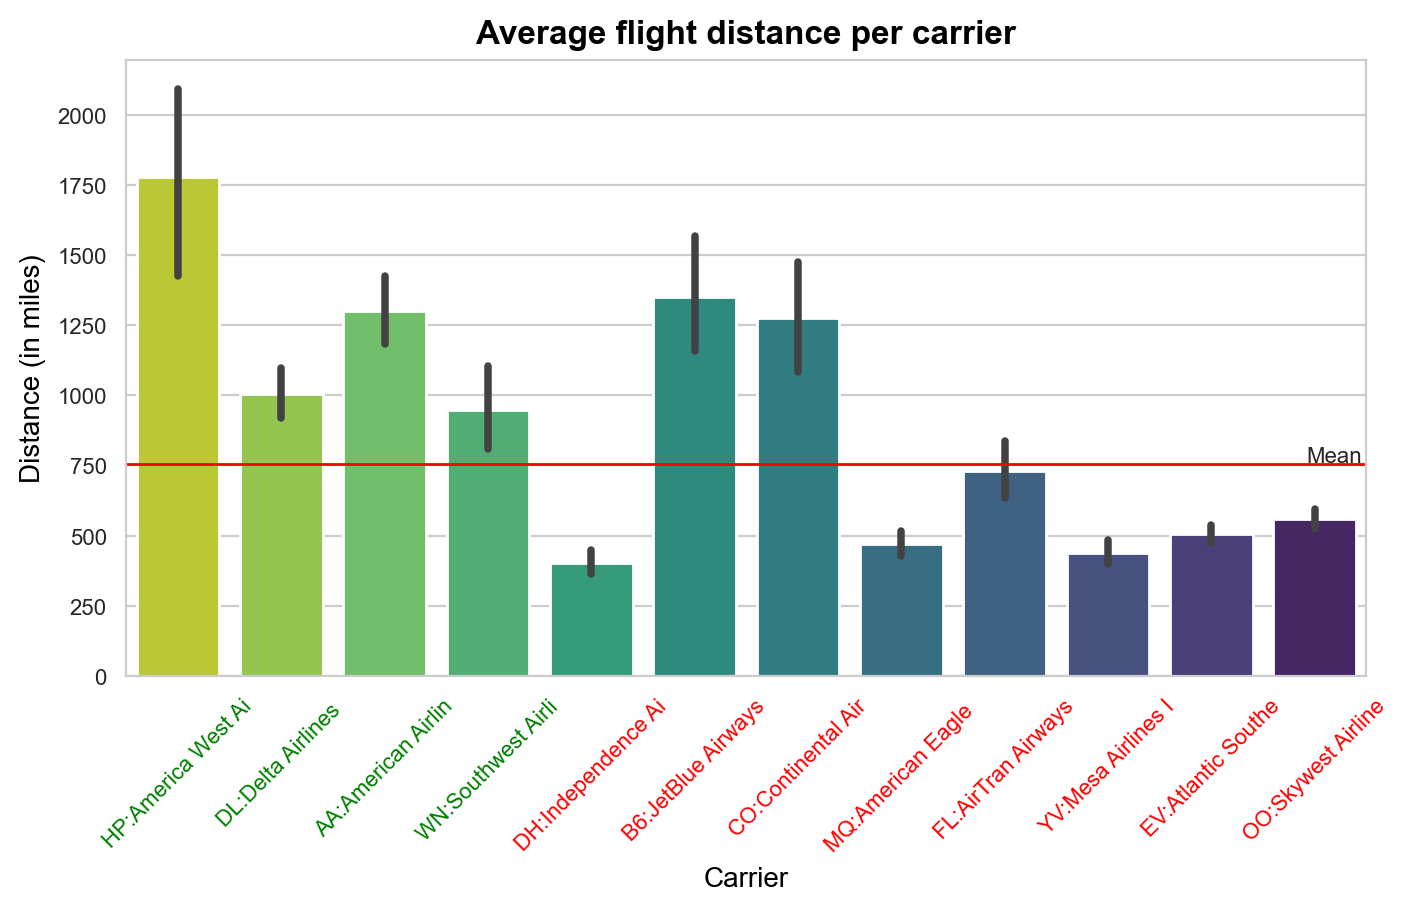

In [30]:
mean_distance = int(flight_stats_final['distance'].mean())
sns.barplot(data=flight_stats_final, x='uniqueCarrier', y='distance', order=problem_carrier_best_worse, palette='viridis_r')
plt.axhline(y=mean_distance, color='r', linewidth=1)

min_xlim, max_xlim = plt.xlim()
plt.text(max_xlim*0.95, mean_distance*1.01, 'Mean')

# indicate which carriers are performing above and below average by setting xtick label to green or red
for ax in plt.gca().get_xticklabels()[:4]:
    ax.set_color('green')
    
for ax in plt.gca().get_xticklabels()[4:]:
    ax.set_color('red')
    
# add carrier description to x-axis
locs, labels = plt.xticks()
plt.xticks(locs, problem_carrier_description_best_worse, fontsize=8, weight='ultralight', rotation=45) 

plt.title('Average flight distance per carrier')
plt.ylabel('Distance (in miles)')
plt.xlabel('Carrier')
plt.show()

<div style="font-size: 12px"> 
<strong>Conclusion:</strong>
<br>Generally, carriers in the problem quadrant (last 8 bars on the right) fly distances around 500 miles, whilst carriers on the left fly longer distances
</div>

<span style="text-align: center; color:blue; font-size:30px; line-height:40px; font-family: Arial Black;">Summary</span>

- Around 77% of flights are on time, where as **21% of flights are delayed**. 
- There is a strong seasonal pattern, the biggest one around **Christmas time in December - March**, and another one during **summer months June - August**. Airports are quieter in spring/autumn months.
- **Mondays, Thursdays and Fridays are the busiest times at airports**, it is the most quiet on Tuesdays and Saturdays. 
- Delays grows progressively throughout the day, with **most delays happening between 17:00-20:00**. Fly early morning or late evening to avoid delays.
- Airports are more busy during peak periods, even though number of flights do not increase. This might be due to an **increase in passengers in airports on fully booked flights**
- Carriers that do repetitive **short-haul** flights per day with **distances around 500 miles**, will have more delays than carriers that does longer distances. Carriers flying longer distances have more time to catch-up delays during the journey.

In [ ]:
# Use this command if you are running this file in local
!jupyter nbconvert Part_III_explanatory_slide_deck.ipynb --to slides --no-input --post serve --no-prompt 

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Part_III_explanatory_slide_deck.ipynb to slides
[NbConvertApp] Writing 4771136 bytes to Part_III_explanatory_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_III_explanatory_slide_deck.slides.html
Use Control-C to stop this server


In [34]:
# convert notebook to html
os.system('jupyter nbconvert --to html Part_III_explanatory_slide_deck.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Part_III_explanatory_slide_deck.ipynb to html
[NbConvertApp] Writing 3072734 bytes to Part_III_explanatory_slide_deck.html


0